In [1]:
from nirs4all.data.predictions import Predictions
import os

# Parquet files to analyze
filenames = [
    "digestibility_custom2",
    "digestibility_custom3",
    "digestibility_custom5",
    "digestibility_0_8",
    "hardness_custom2",
    "hardness_custom4",
    "hardness_0_8",
    "tannin_custom2",
    "tannin_custom3",
    "tannin_0_8"
]

# ========================================
# MODEL FILTERING AND RENAMING CONFIG
# ========================================

# Models to exclude from analysis (case-insensitive partial match)
EXCLUDE_MODELS = ["KernelPLS"]

# Model renaming: {pattern: new_name}
# Case-insensitive partial match - replaces entire model name if pattern is found
# Suffixes like "Classifier"/"Regressor" are stripped automatically before renaming
MODEL_RENAME_MAP = {
    "dict": "nicon",
    "tabpfn": "transformer",        # Matches TabPFNClassifier, TabPFNRegressor, etc.
    "tunedtabpfn": "tuned_transformer",  # More specific pattern first if needed
}

# ========================================

# folders = ["wk_src", "wk_tabpfn", "wk_denis", "wk_denis_0", "wk_local"]

# for file in filenames:
#     input_files = []
#     for folder in folders:
#         if os.path.exists(f"{folder}/{file}.meta.parquet"):
#             input_files.append(f"{folder}/{file}.meta.parquet")

#     output_file = f"{file}.meta.parquet"
#     Predictions.merge_parquet_files(
#         input_files=input_files,
#         output_file=f"wk/{output_file}",
#         deduplicate=True  # Remove duplicate prediction IDs (default)
#     )


WORKSPACE_PATH = "wk"

In [2]:
# Reload modules
import importlib
import nirs4all.data._predictions.ranker as ranker_module
import nirs4all.data._predictions.storage as storage_module
import nirs4all.data.predictions as predictions_module
import nirs4all.visualization.charts.confusion_matrix as cm_module
importlib.reload(ranker_module)
importlib.reload(storage_module)
importlib.reload(predictions_module)
importlib.reload(cm_module)

from nirs4all.data.predictions import Predictions
from nirs4all.visualization.predictions import PredictionAnalyzer

wk/digestibility_custom2.meta.parquet

 Loaded 1414 predictions from digestibility_custom2
   Stripped suffixes from model names: ['AdaBoostClassifier', 'CatBoostClassifier', 'ExtraTreesClassifier', 'KNeighborsClassifier', 'LGBMClassifier', 'MLPClassifier', 'RandomForestClassifier', 'RidgeClassifier', 'SGDClassifier', 'StackingClassifier', 'TabPFNClassifier', 'TunedTabPFNClassifier', 'XGBClassifier']
   Renamed 63 predictions matching 'dict'  'nicon'
   Renamed 117 predictions matching 'tabpfn'  'transformer'
   Using 1414 predictions after filtering
   Task type: Classification

 Top 5 models for digestibility_custom2:
  1. transformer: balanced_accuracy=1.0000
  2. transformer: balanced_accuracy=1.0000
  3. transformer: balanced_accuracy=1.0000
  4. transformer: balanced_accuracy=1.0000
  5. transformer: balanced_accuracy=1.0000

=== Charts for digestibility_custom2 ===

 Confusion matrix:
   Saved: charts\digestibility_custom2_confusion_matrix_balanced_accuracy.png
   Saved: charts\

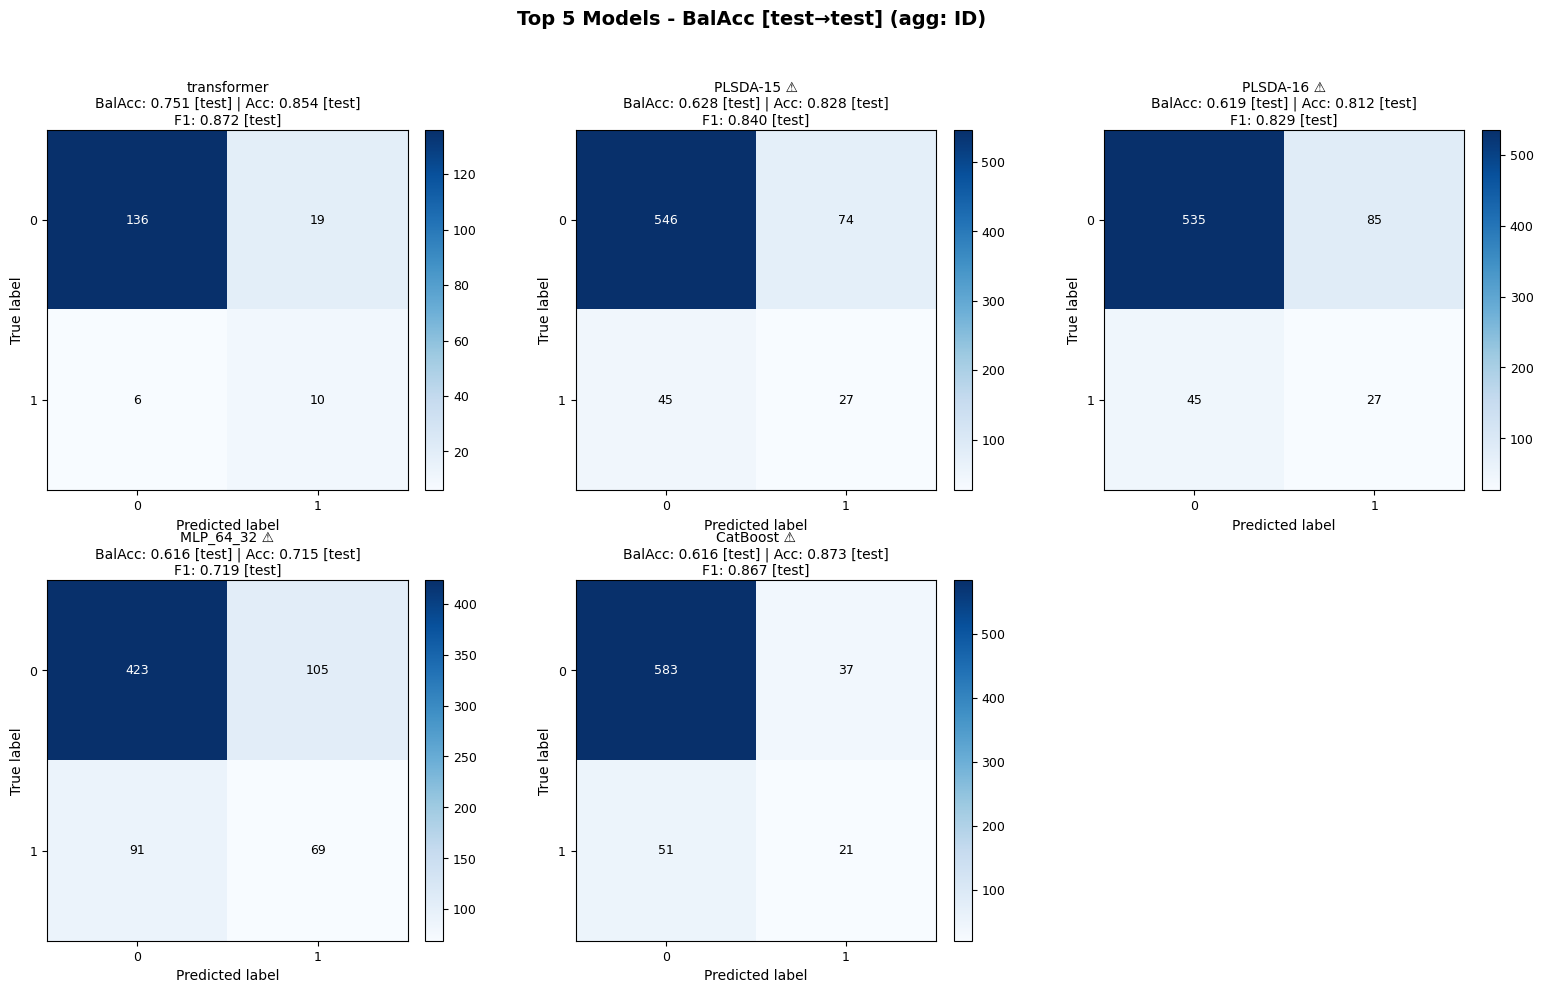

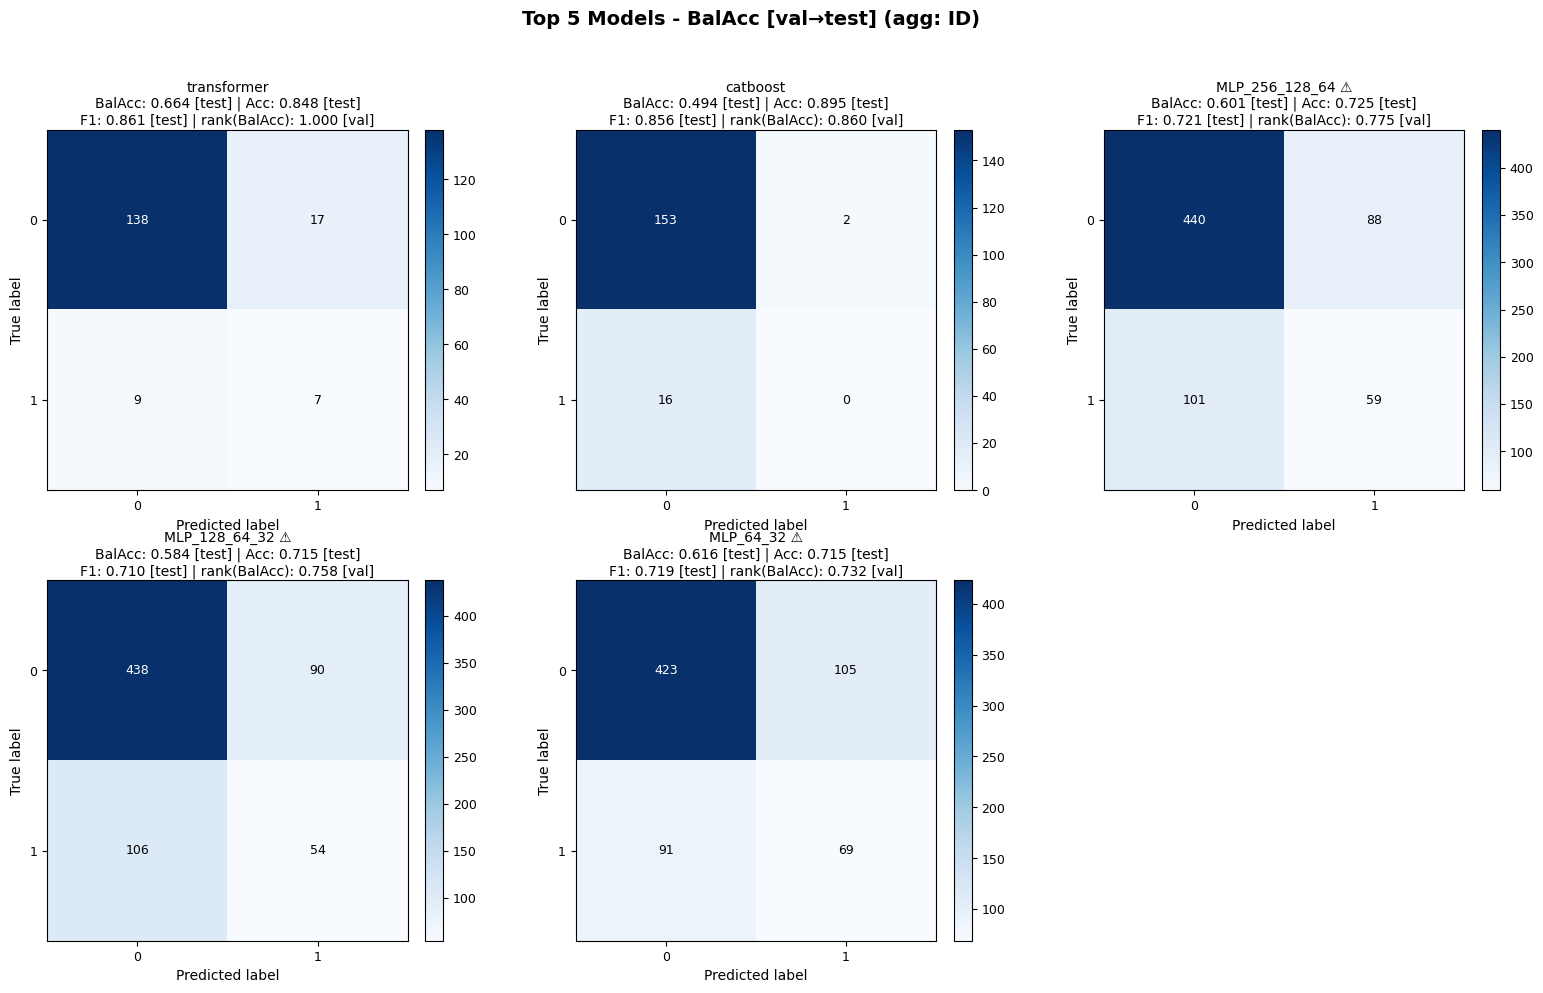

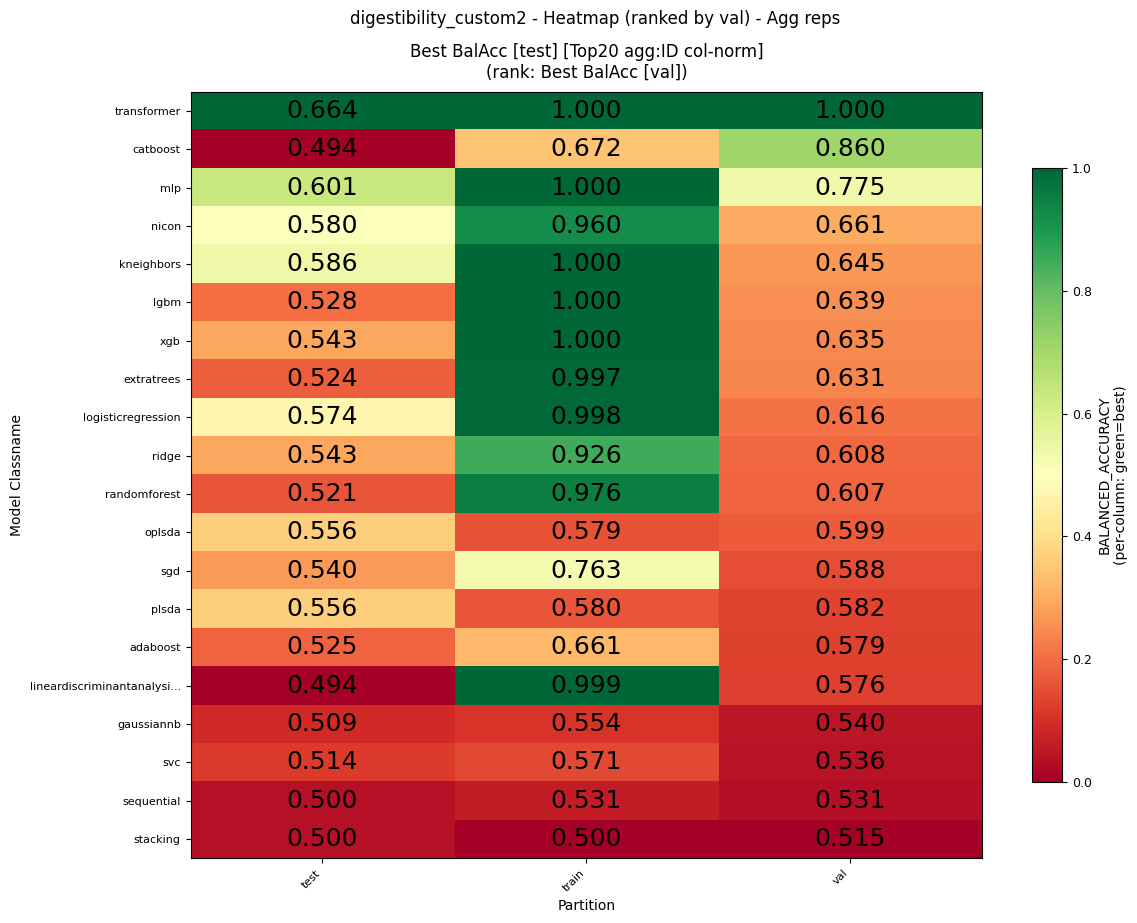

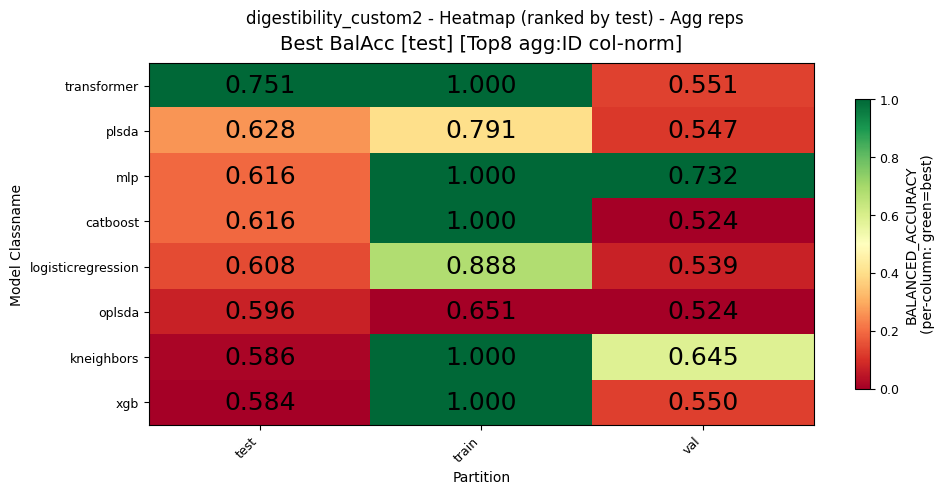

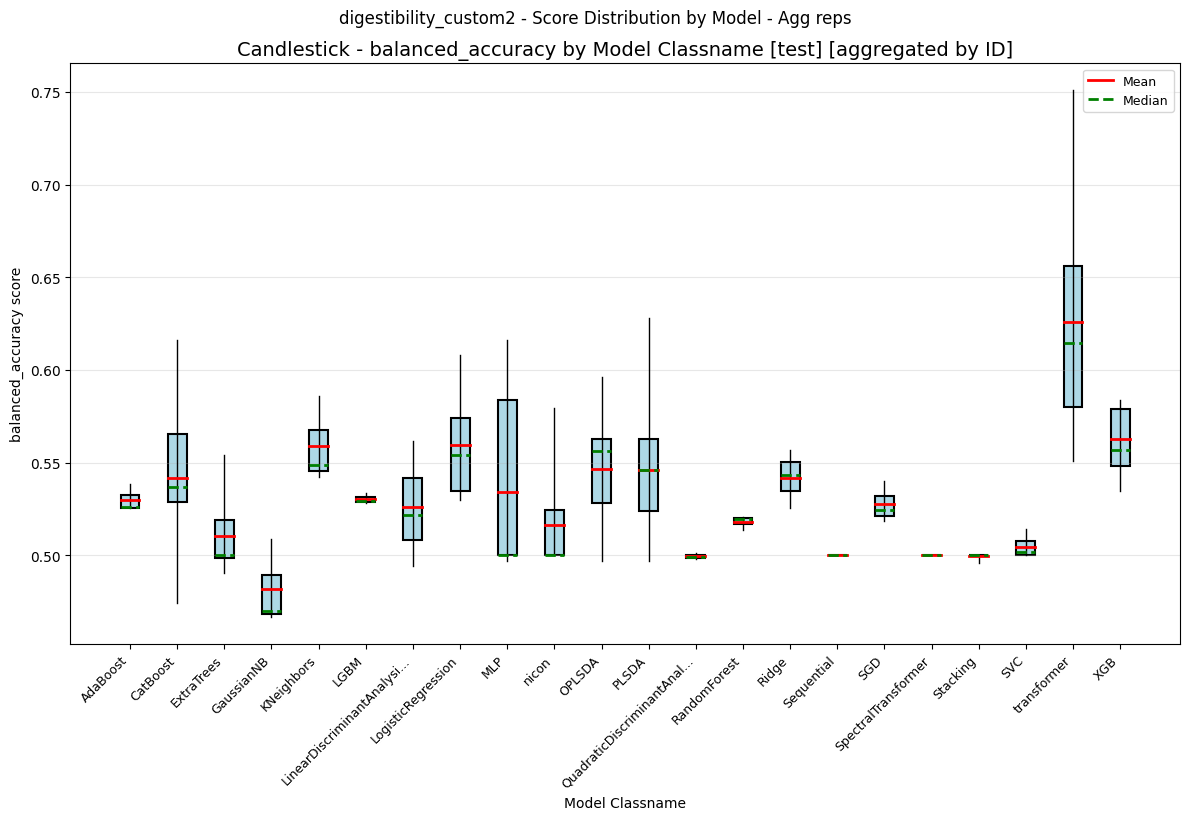

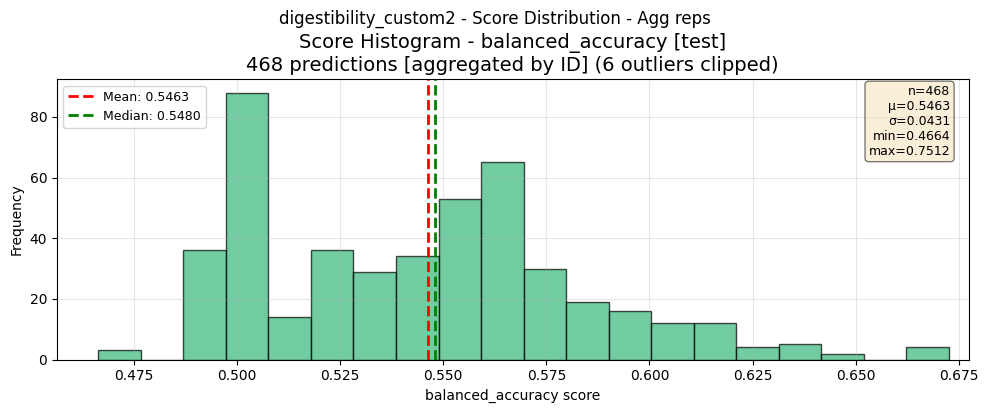

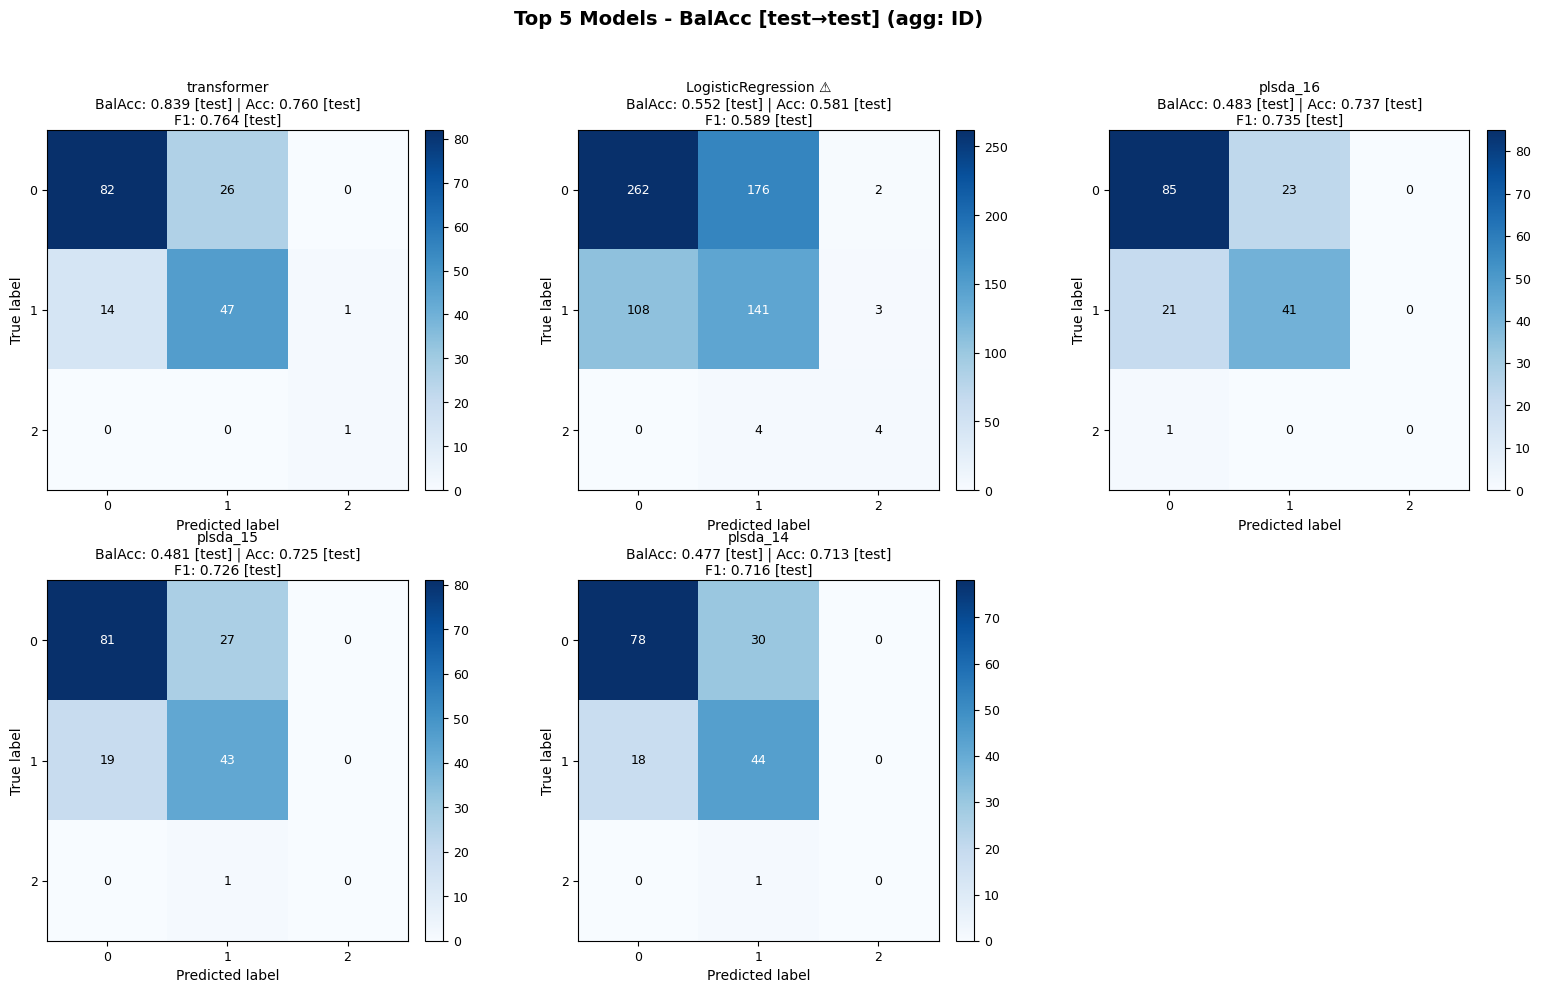

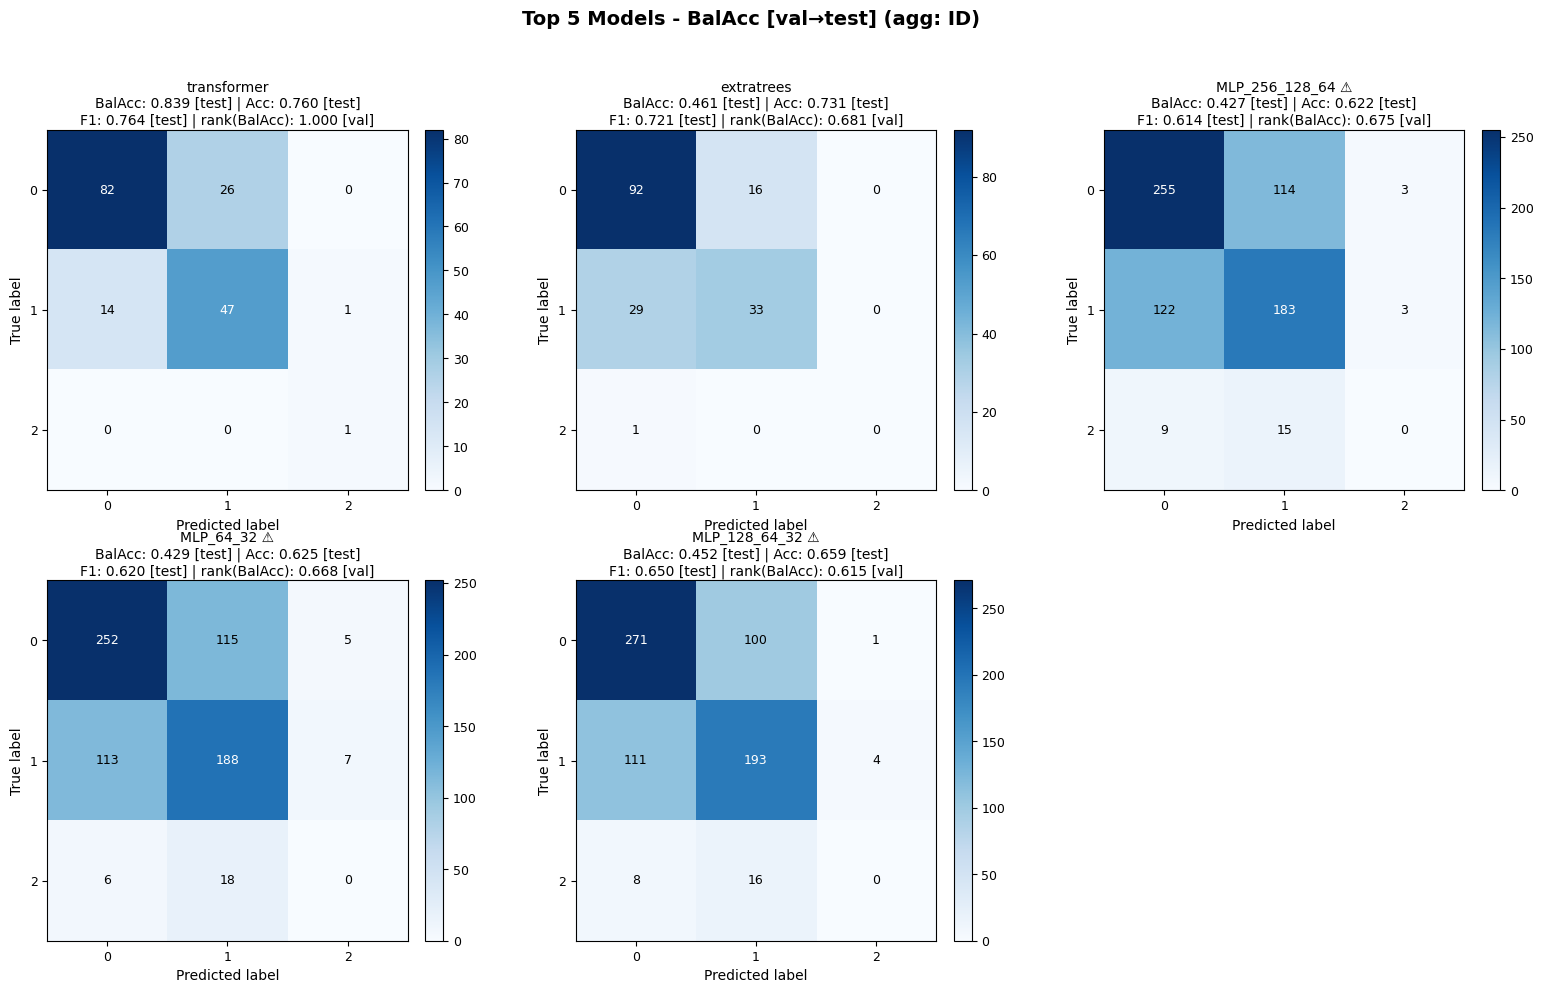

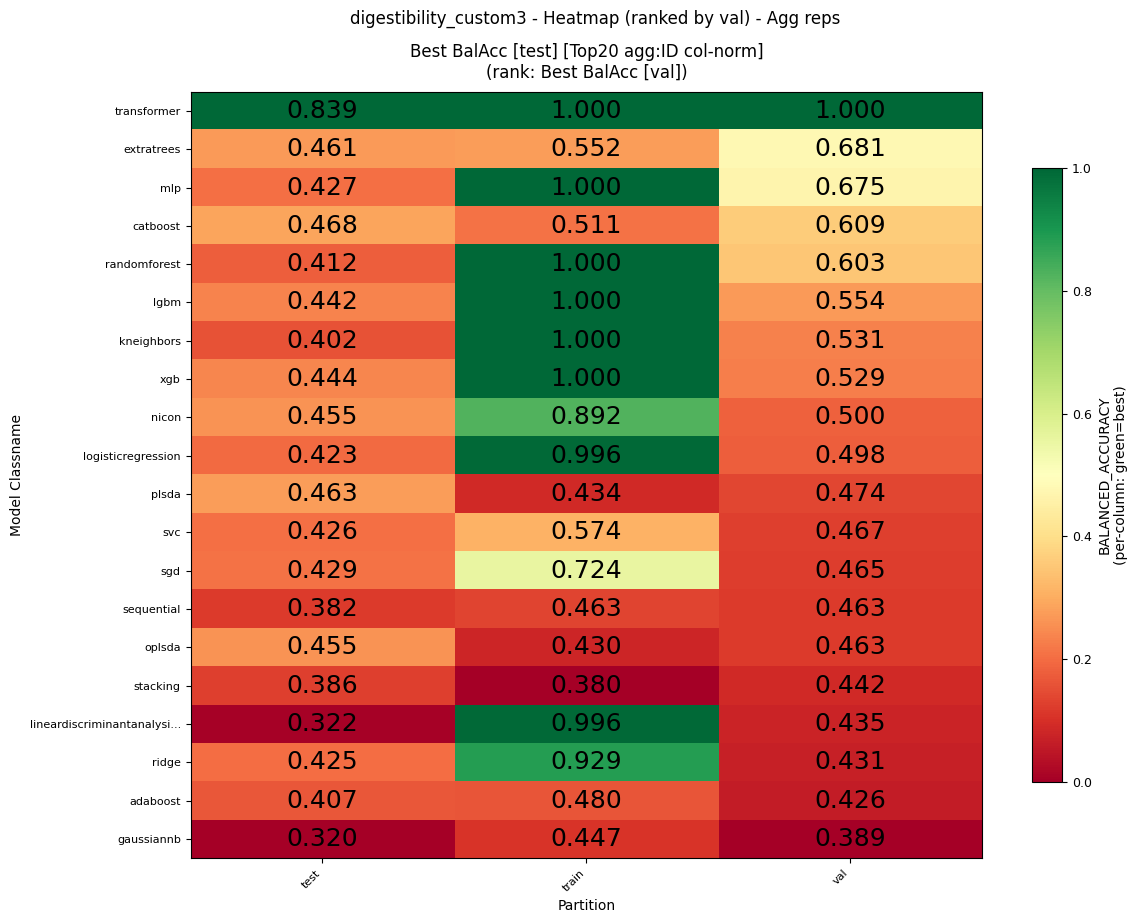

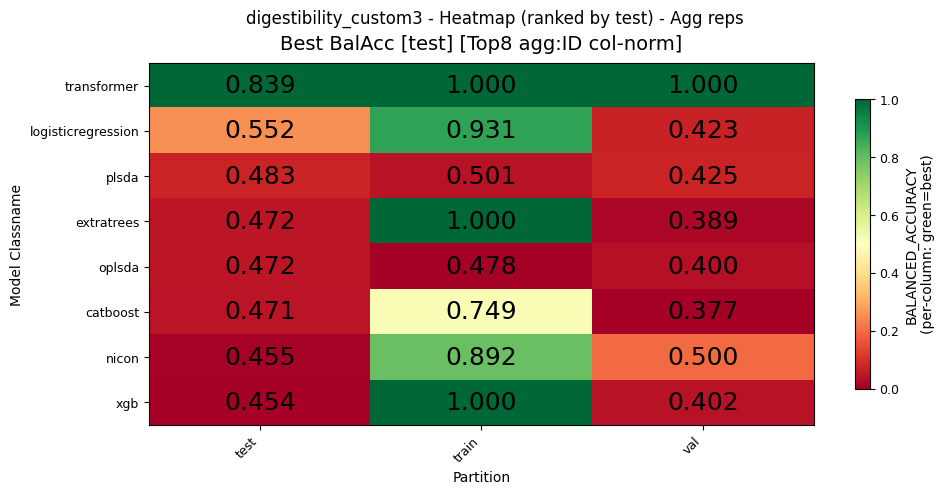

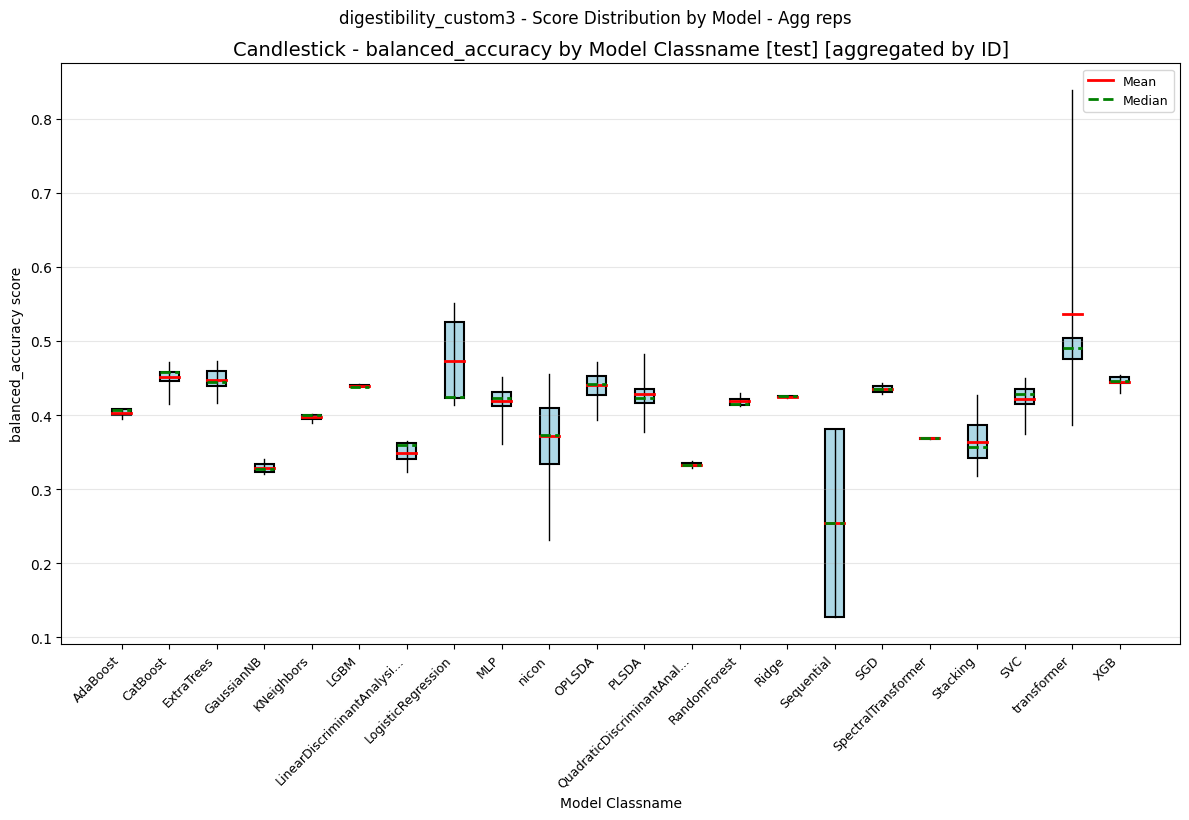

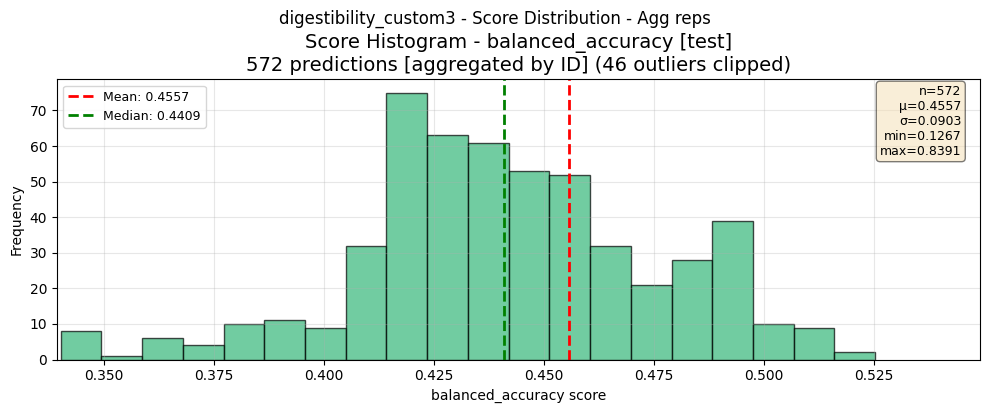

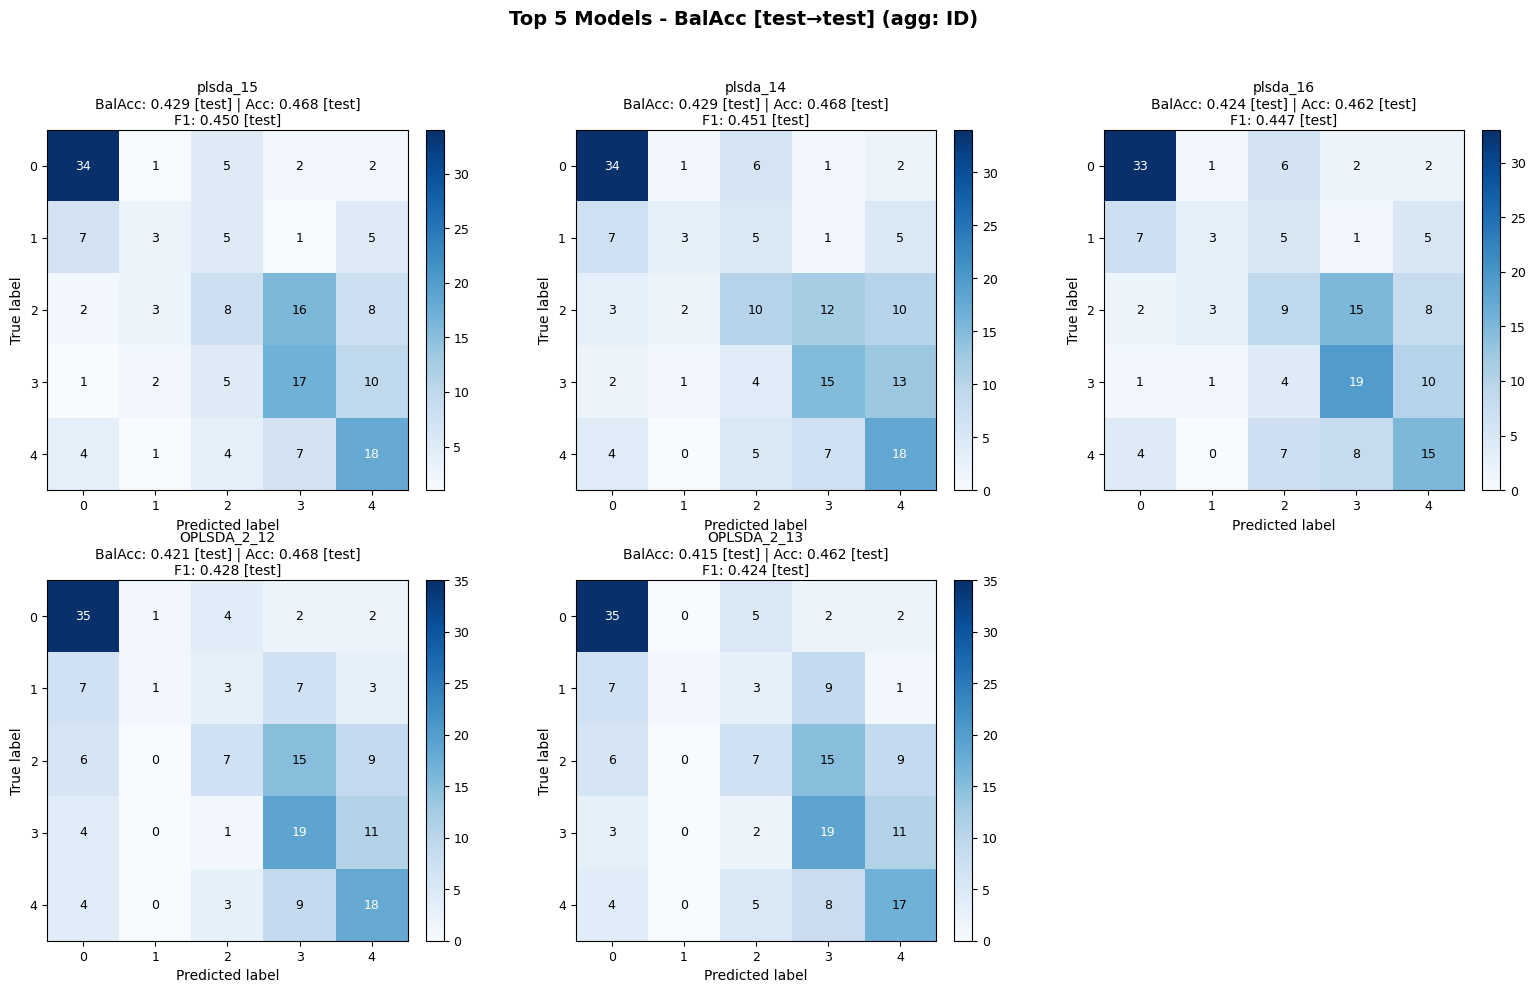

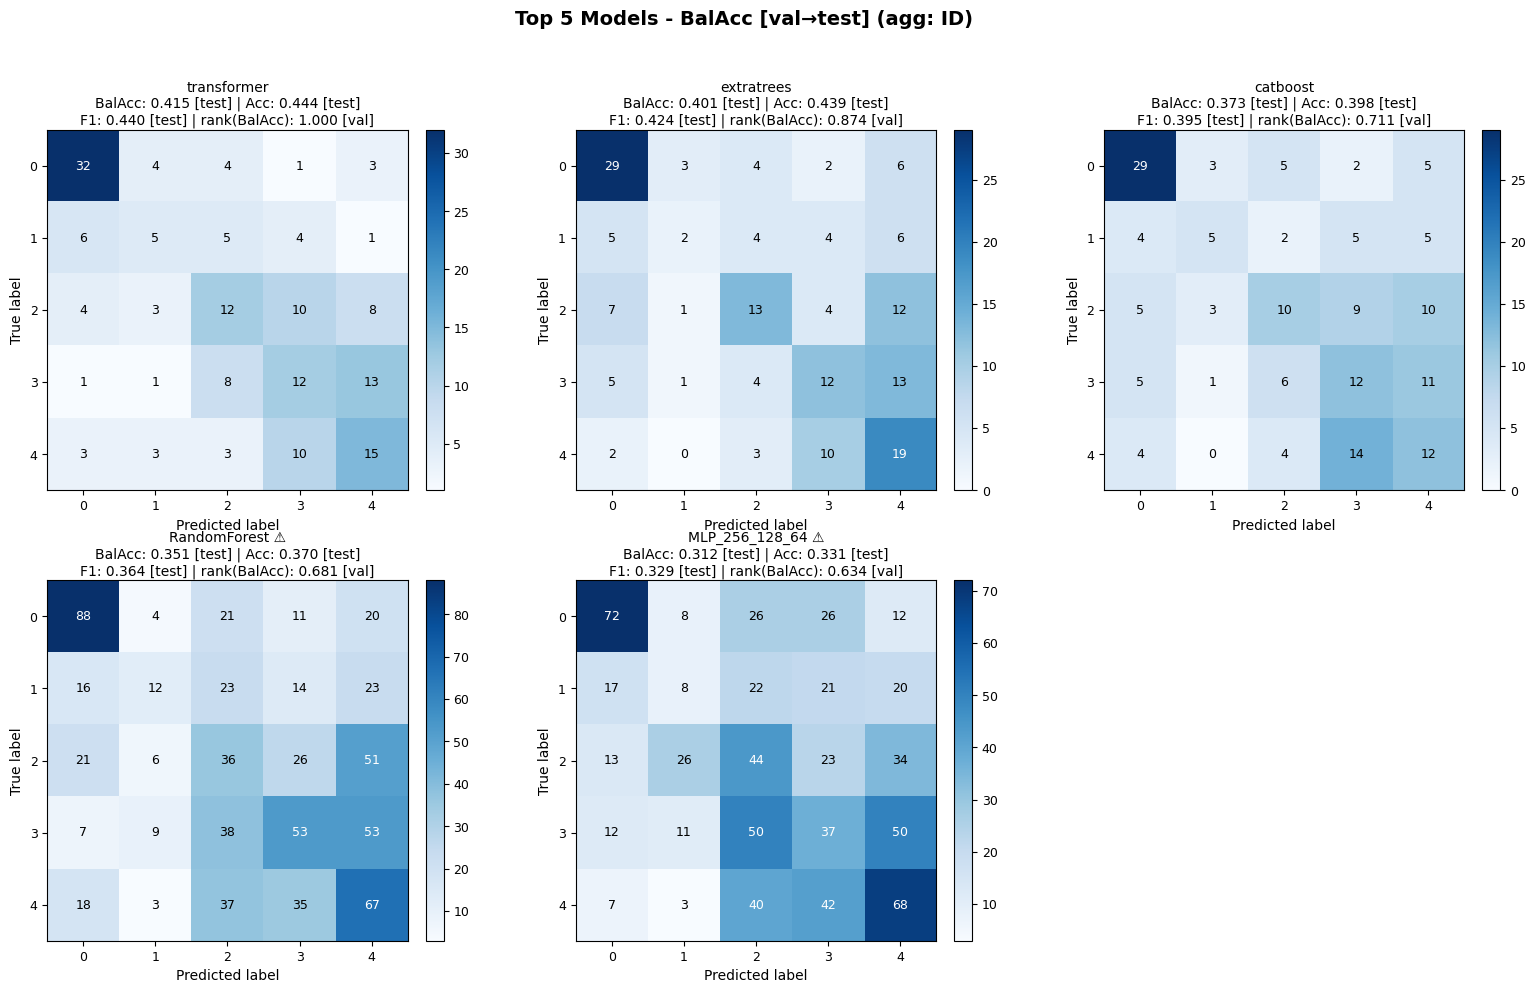

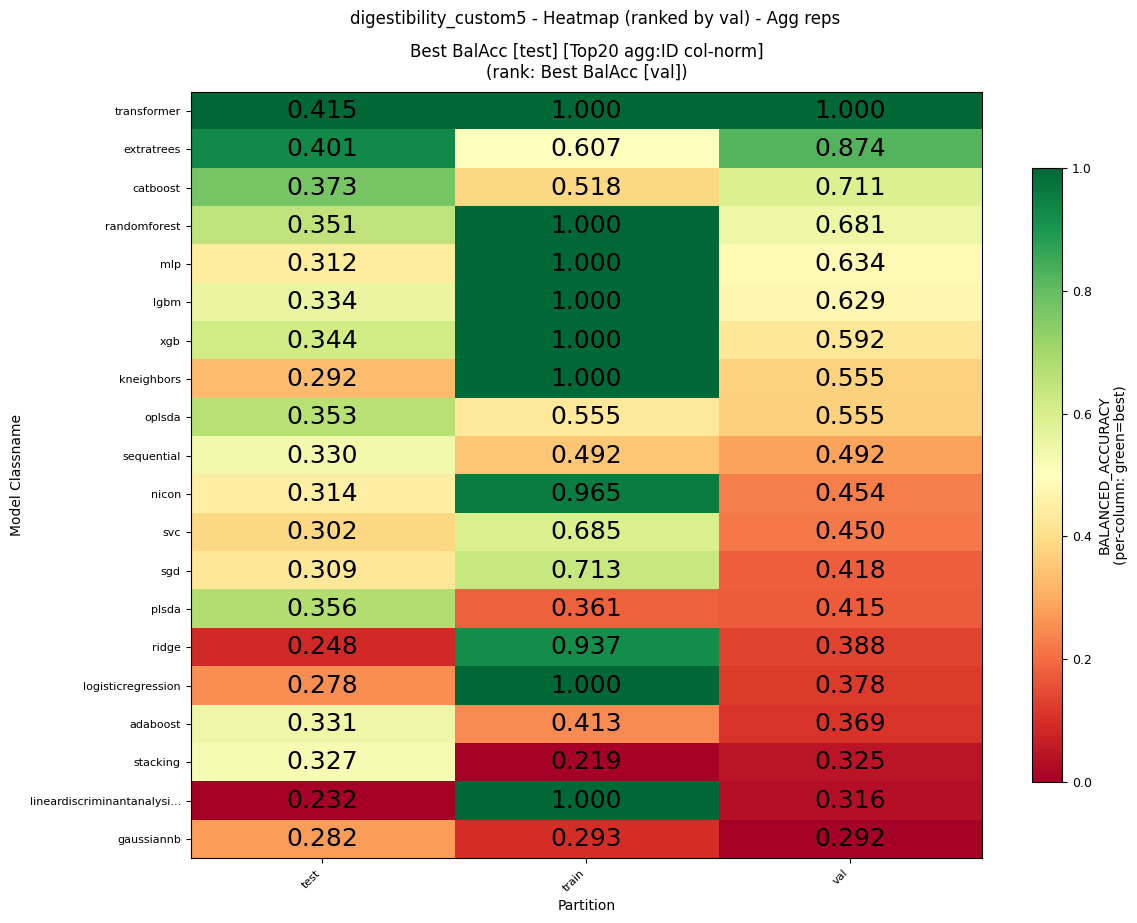

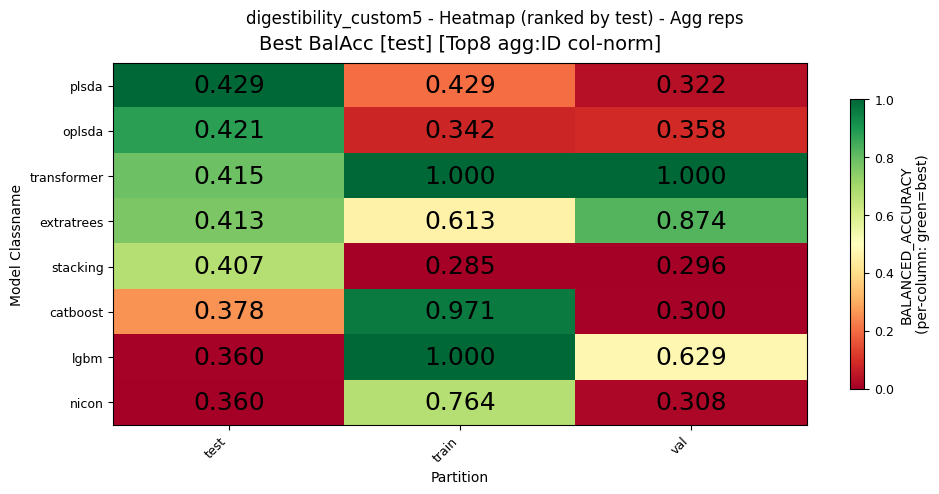

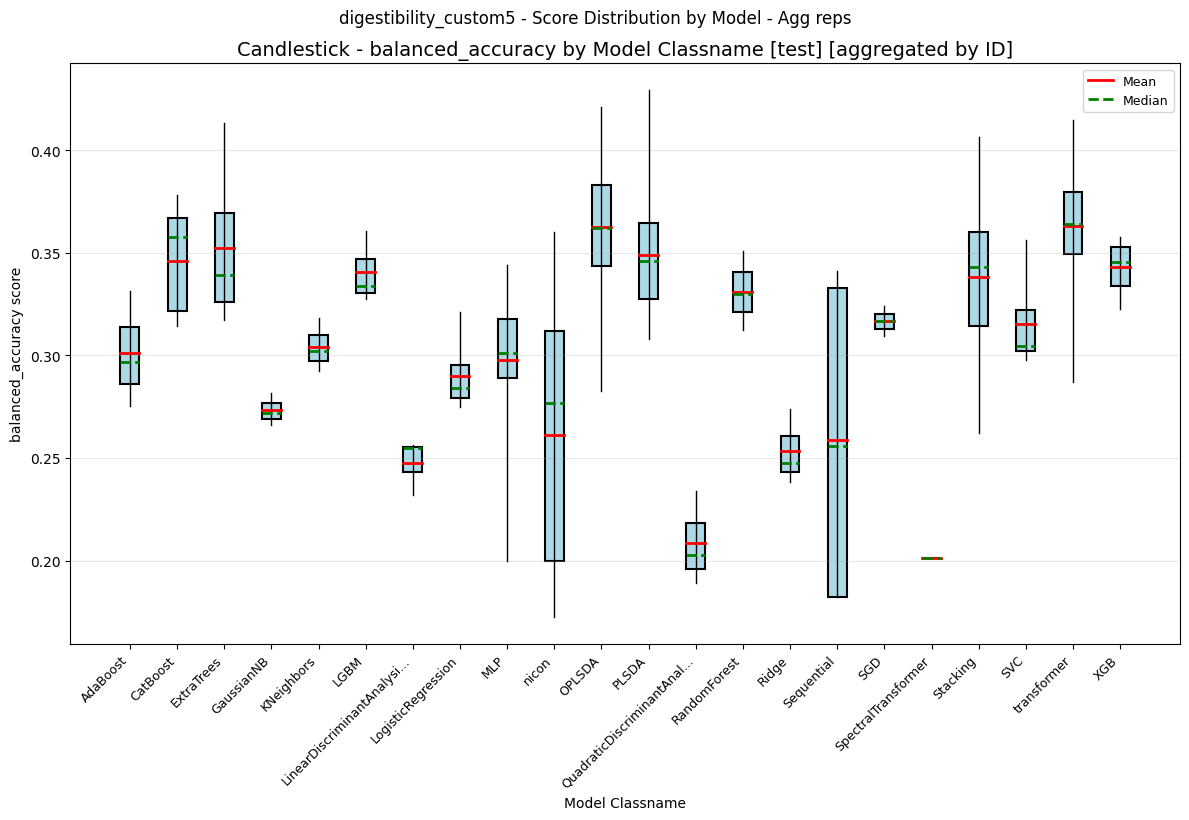

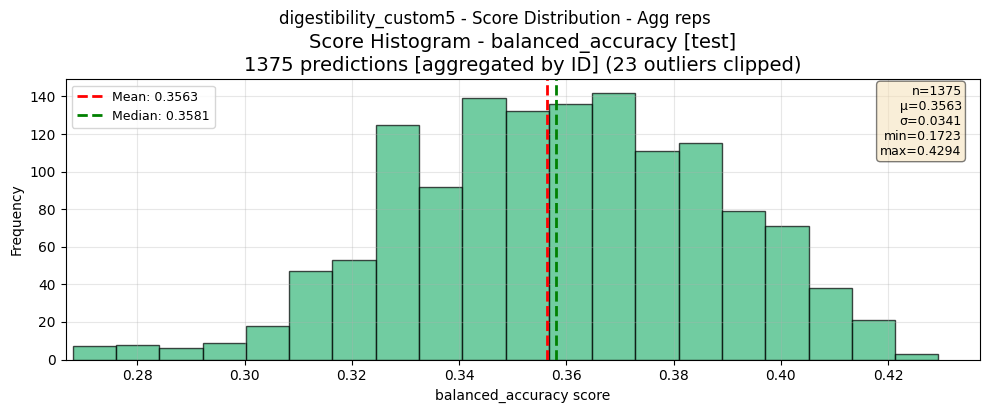

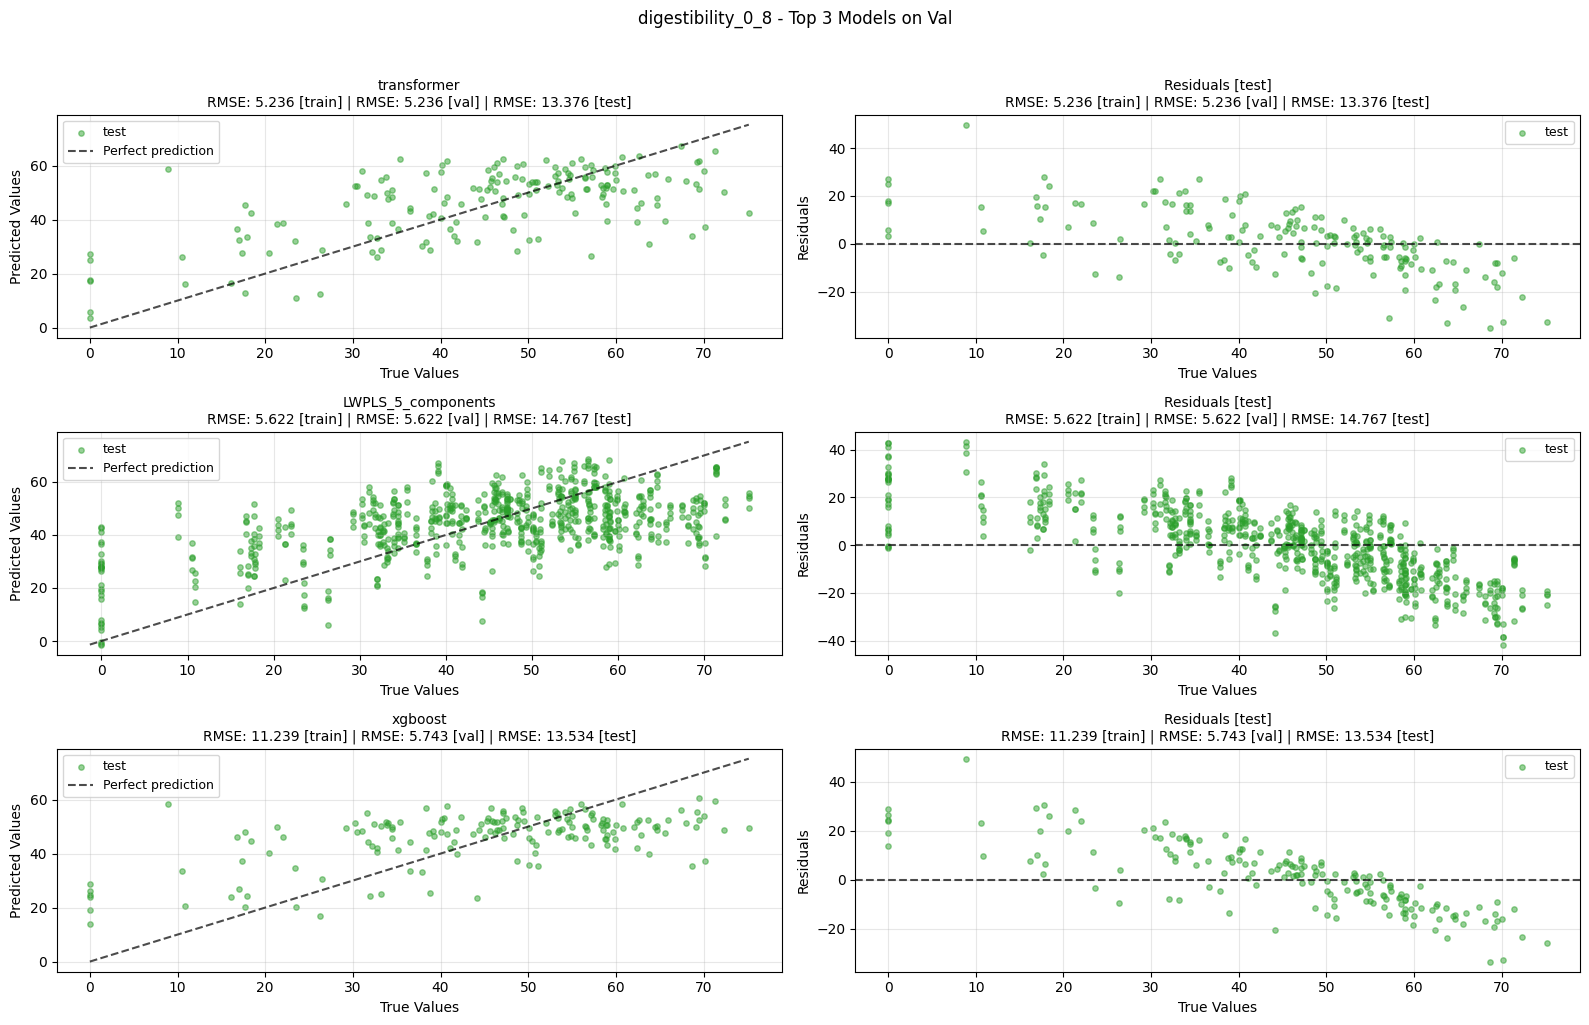

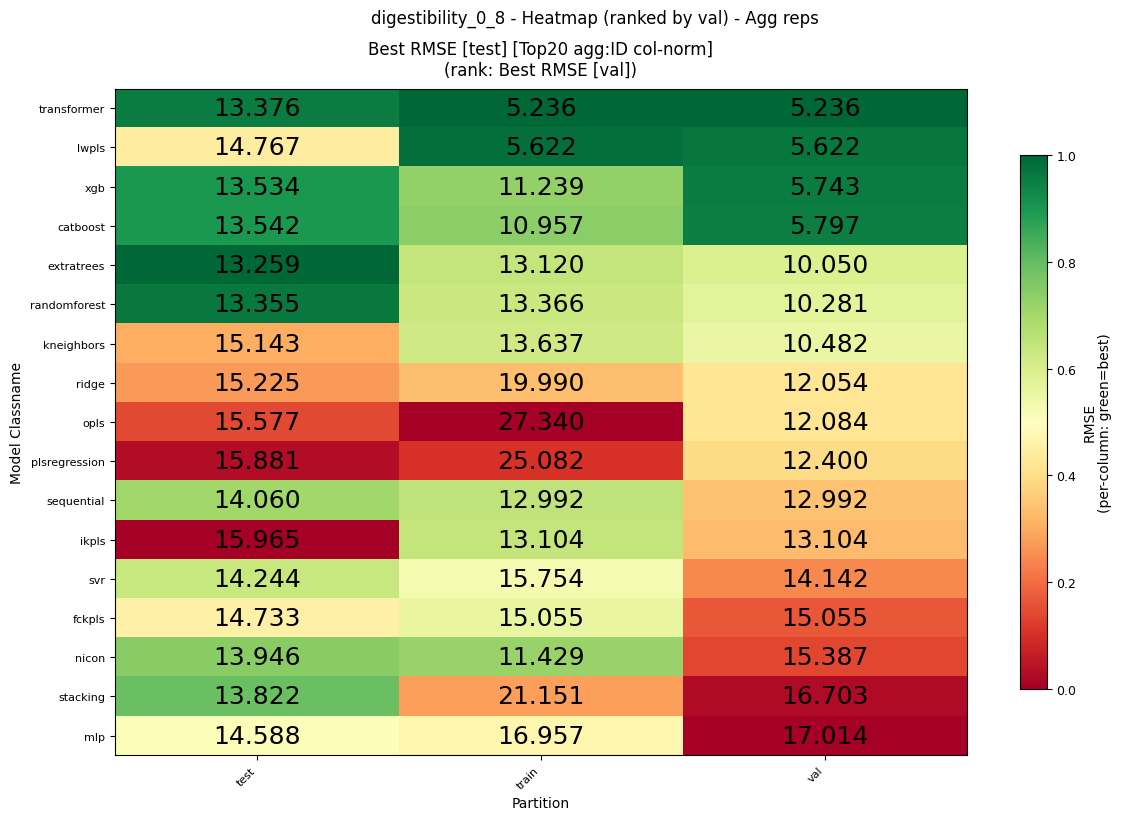

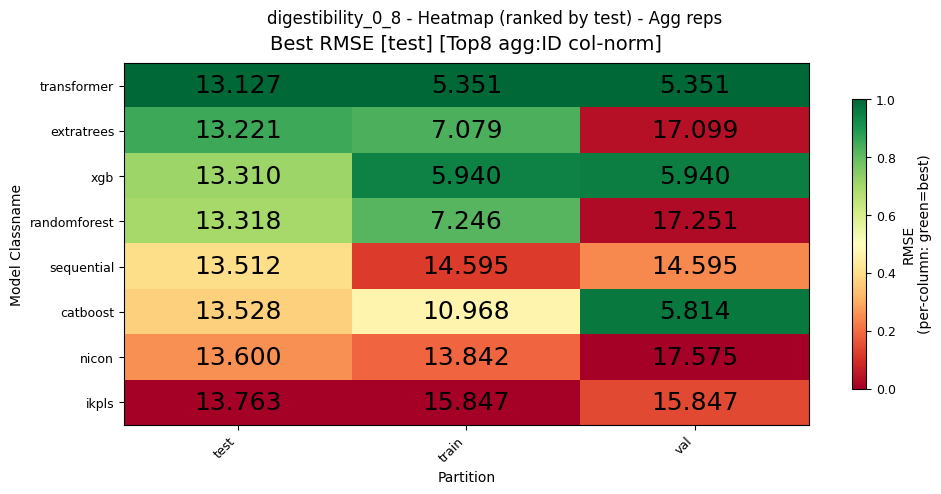

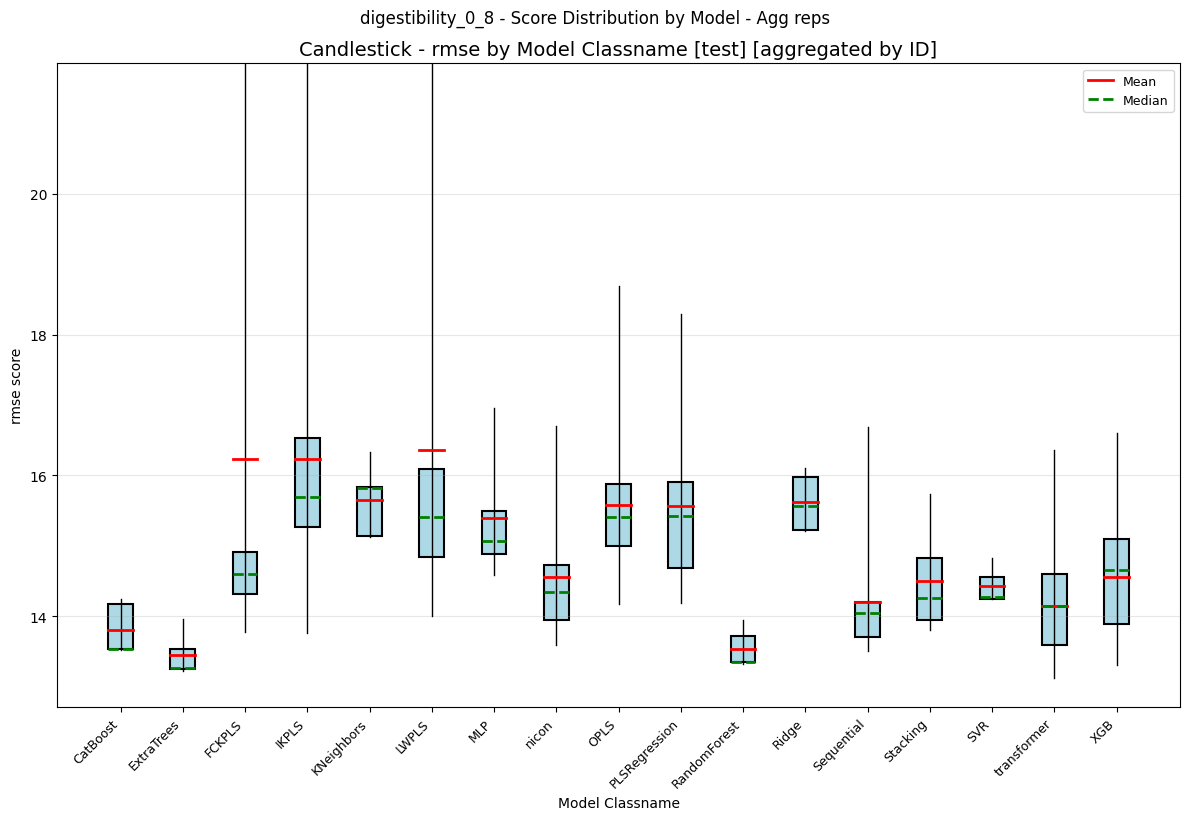

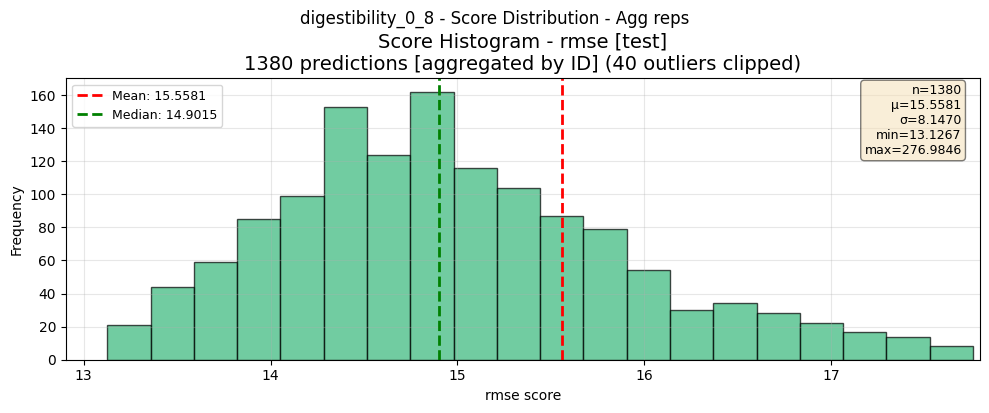

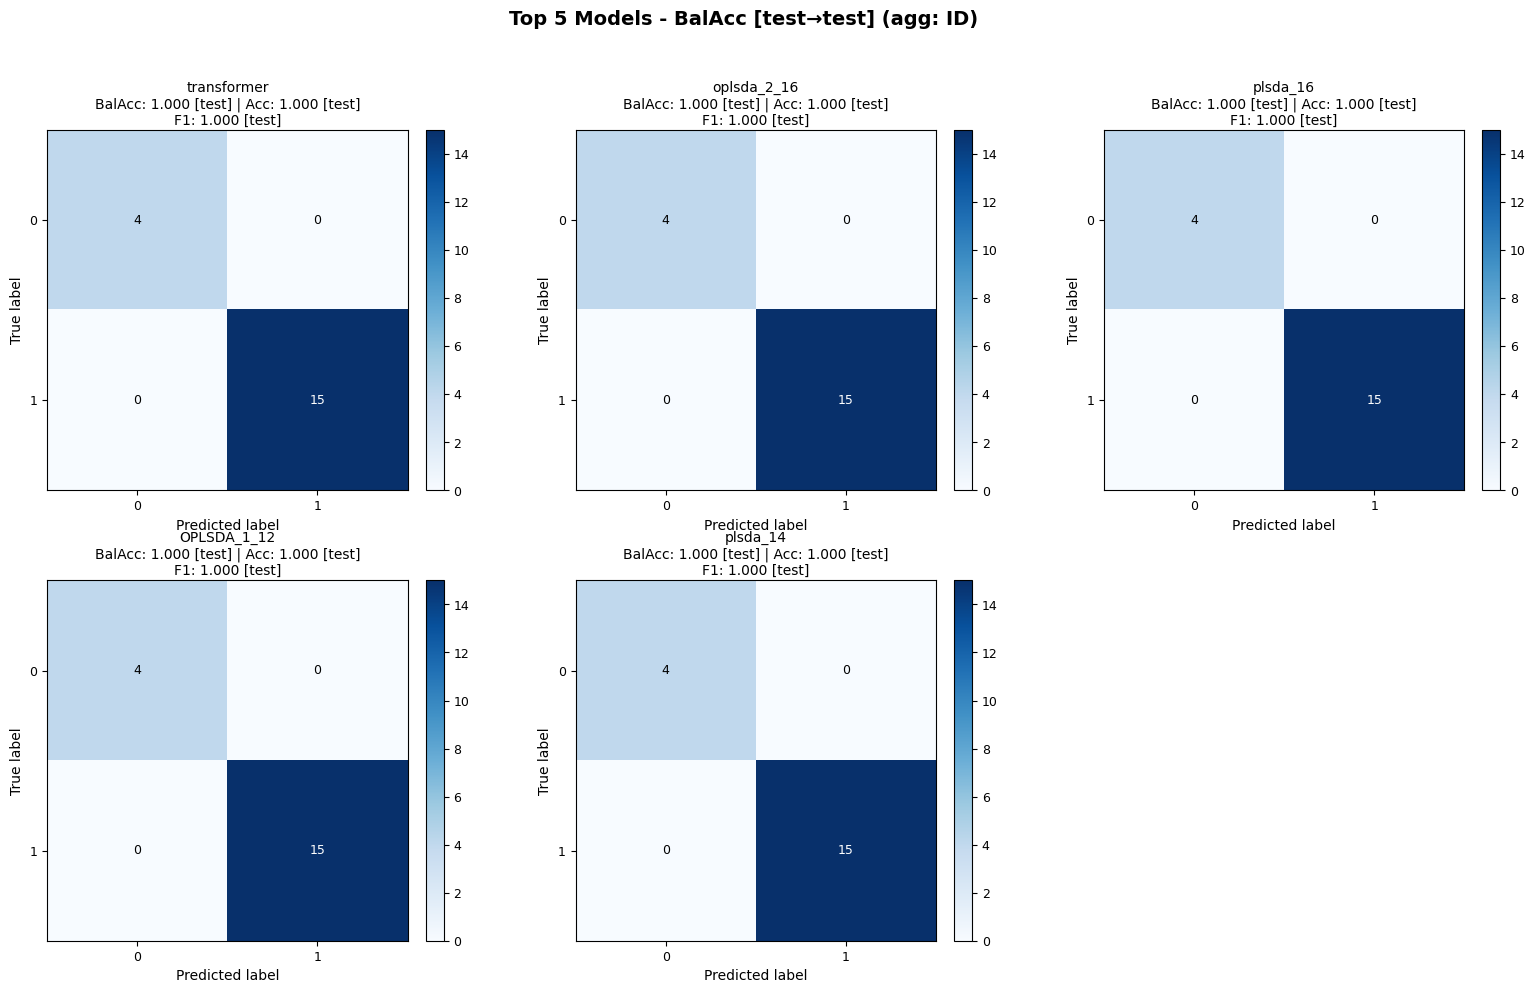

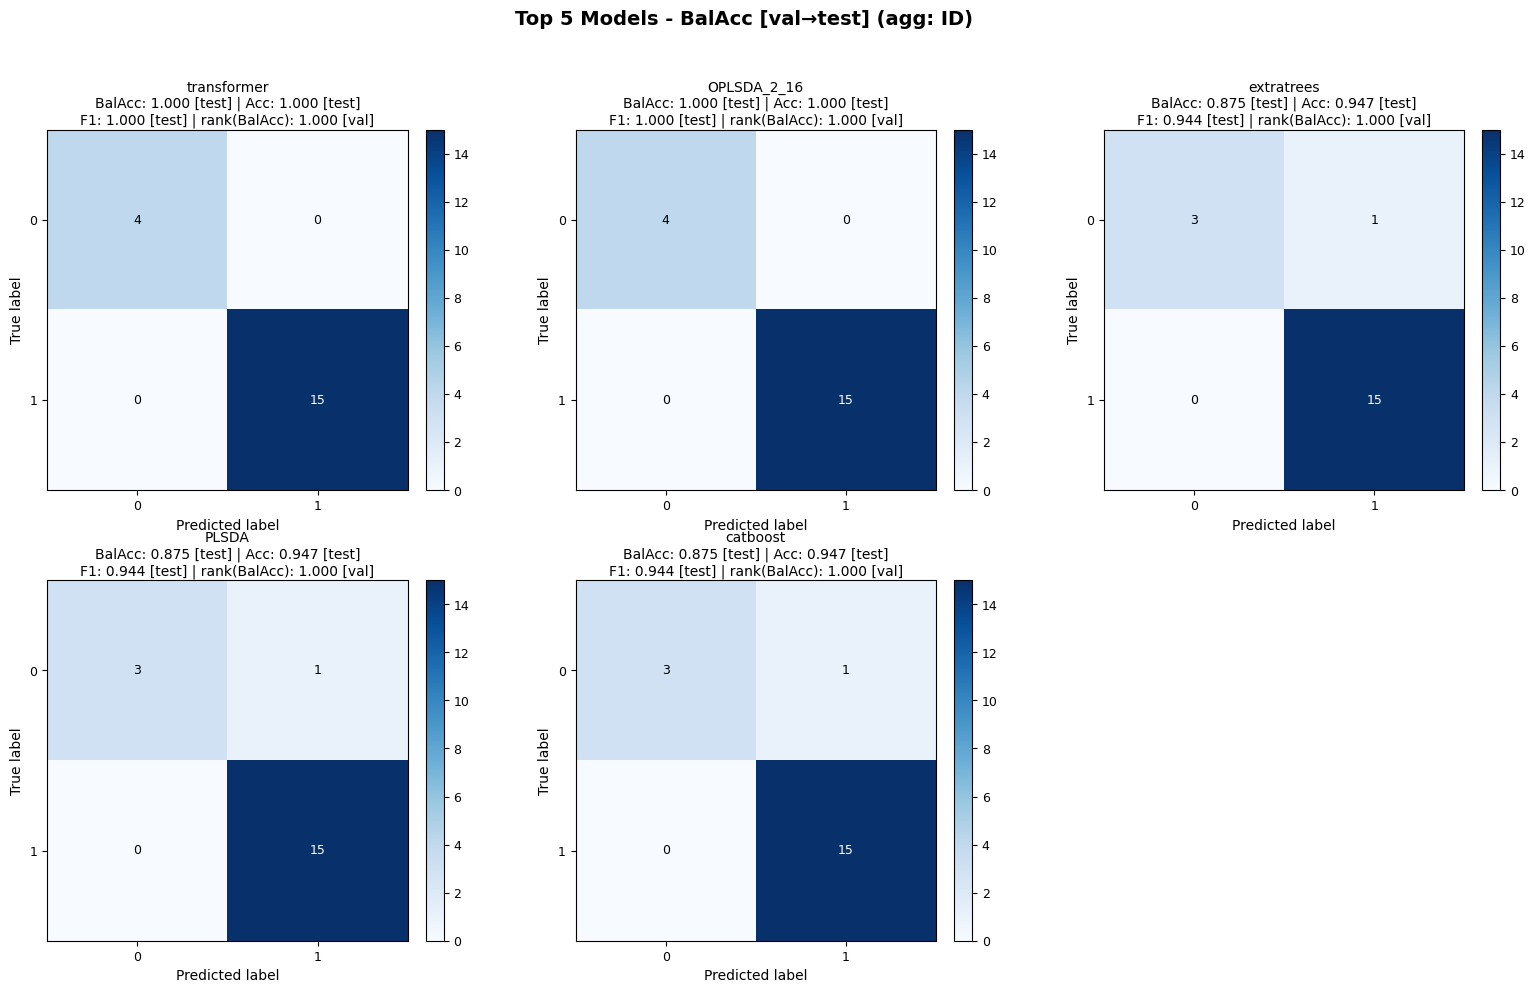

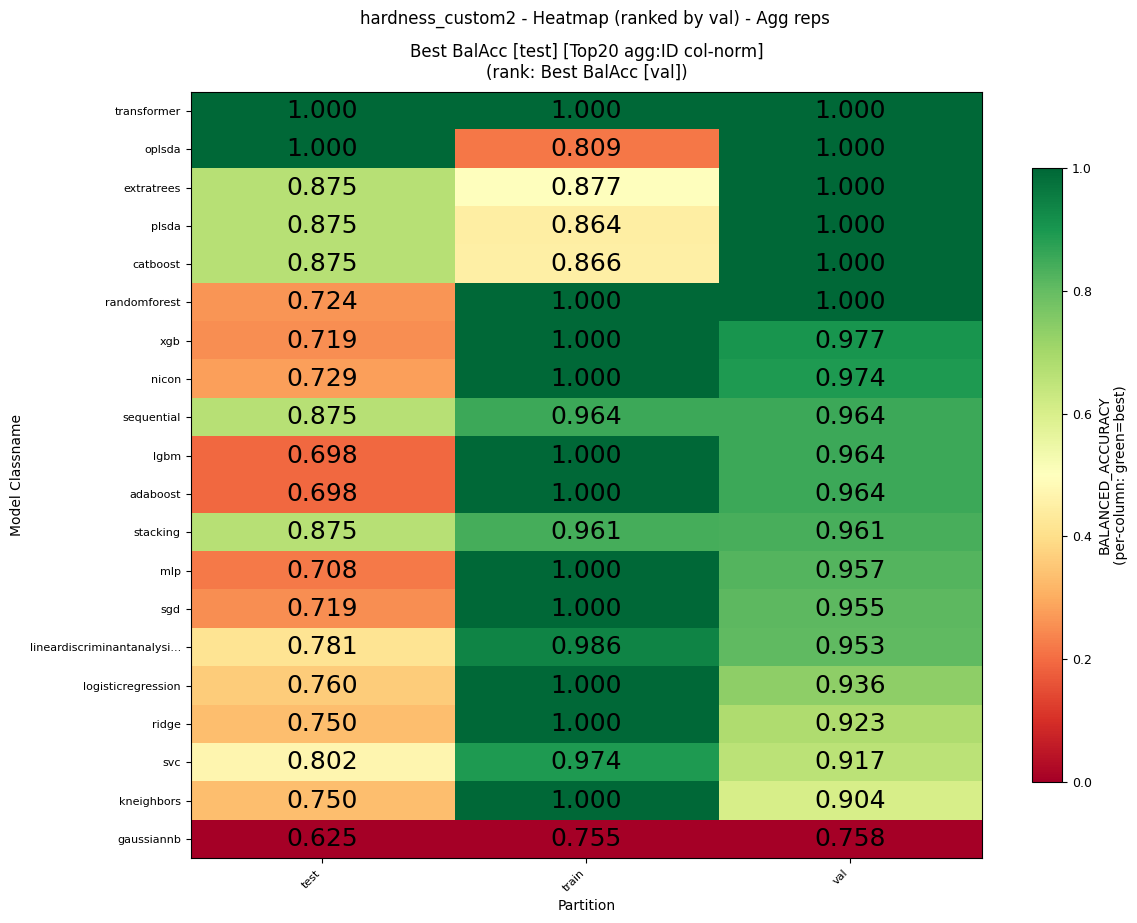

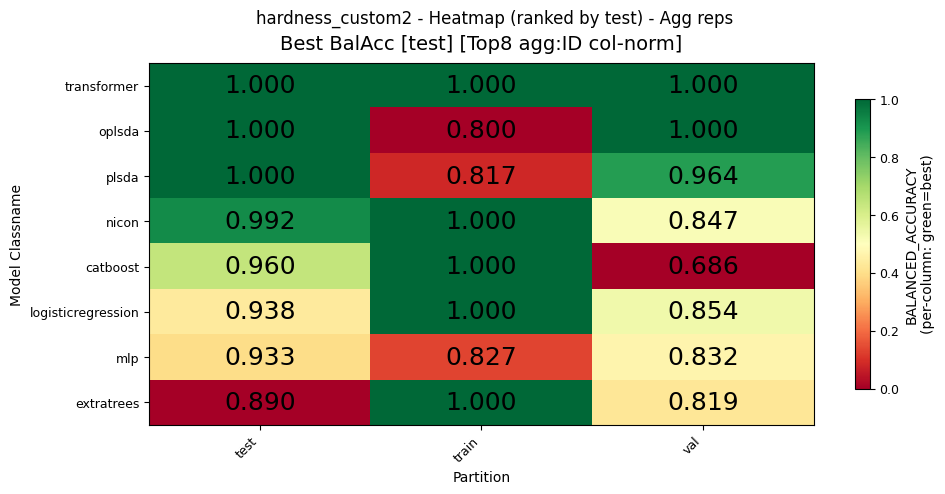

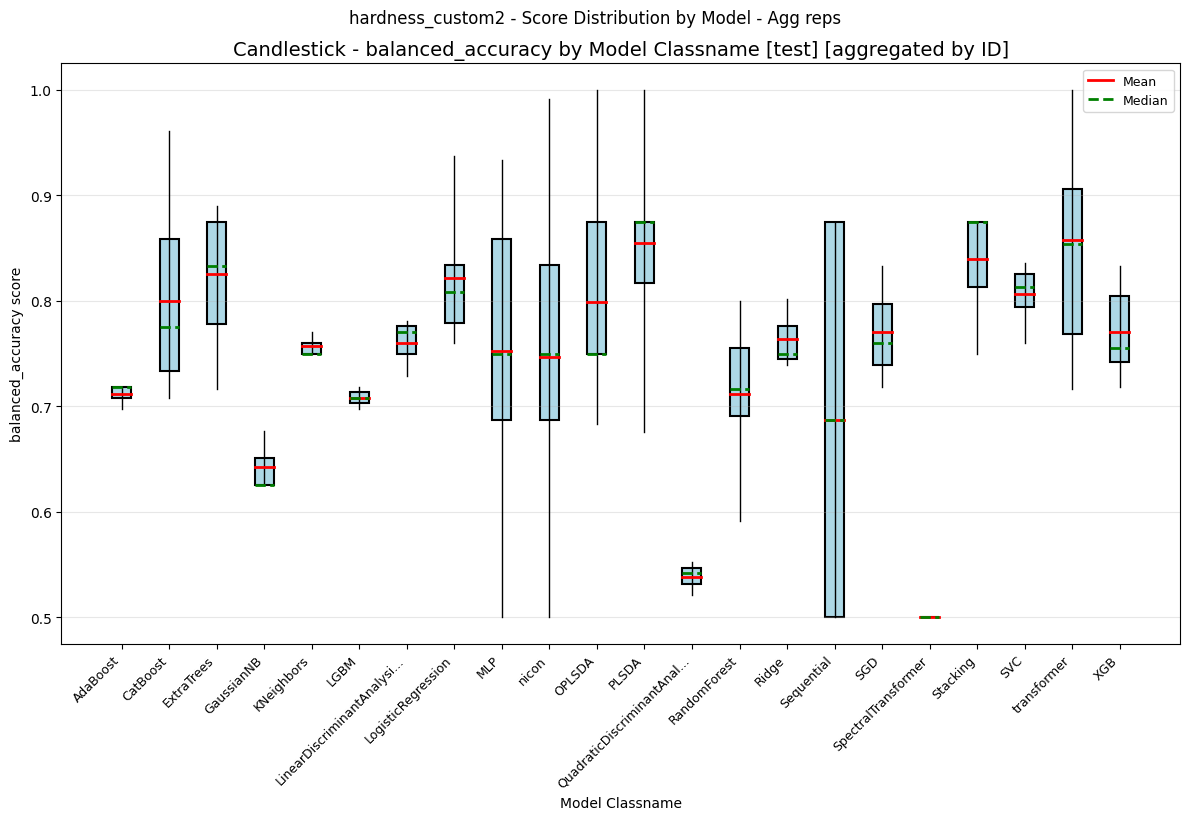

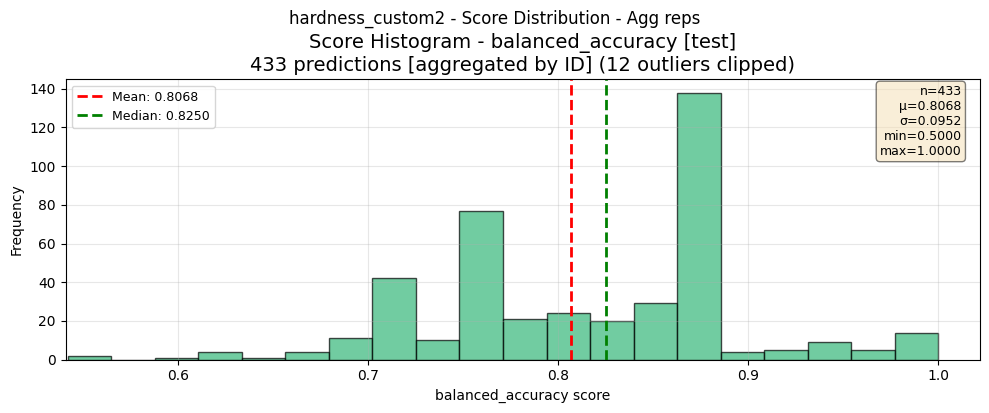

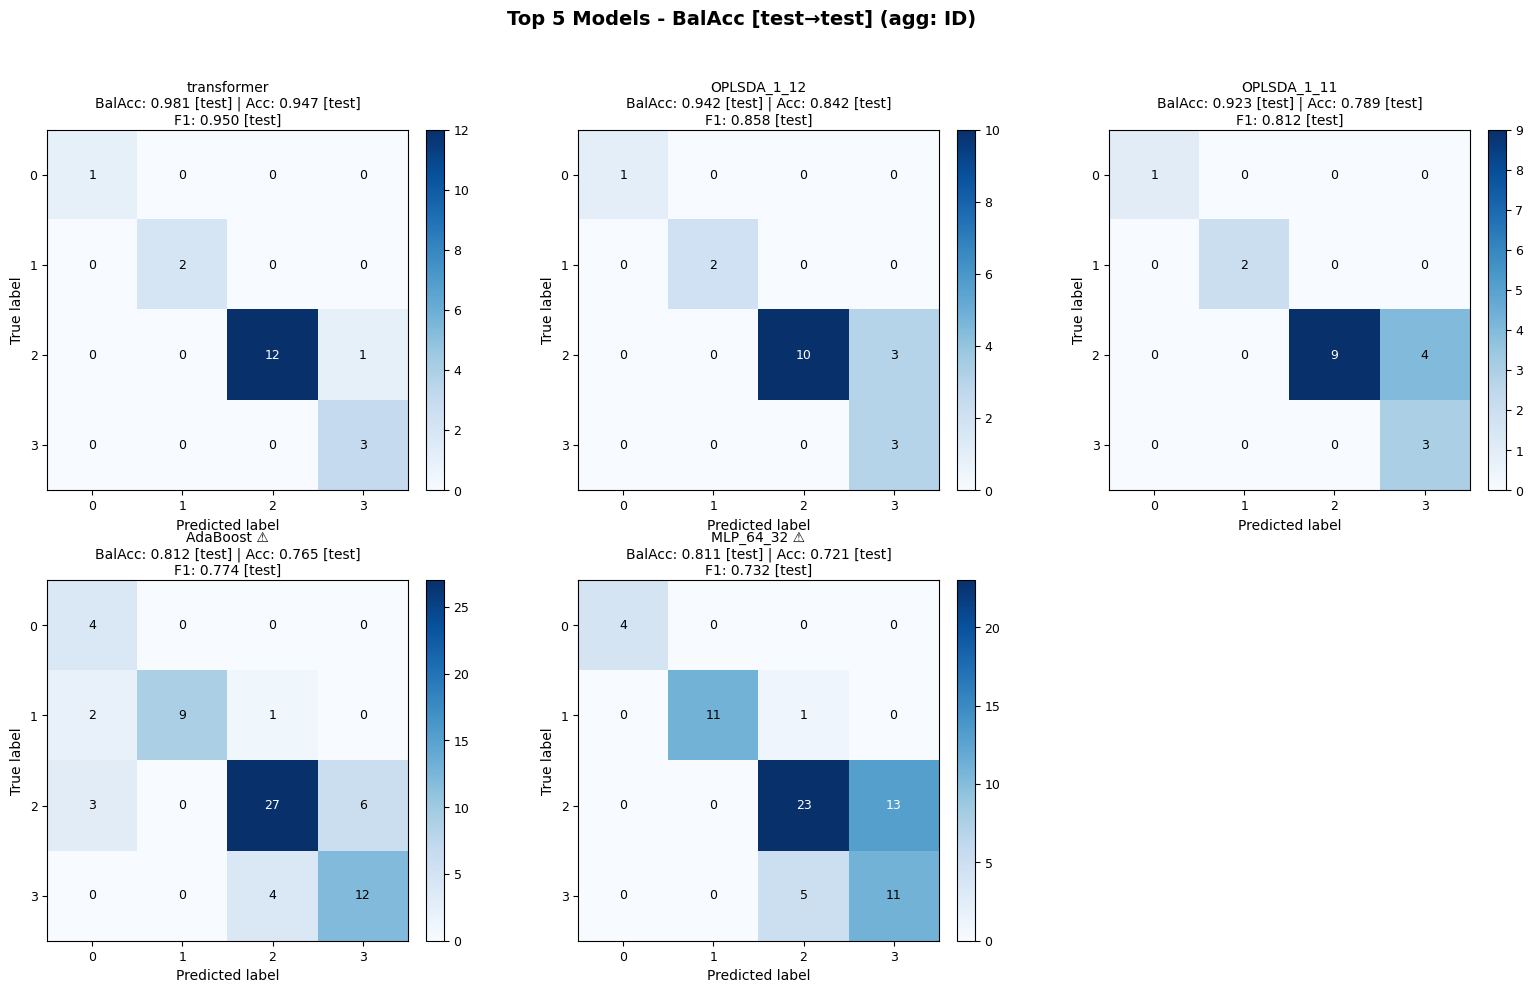

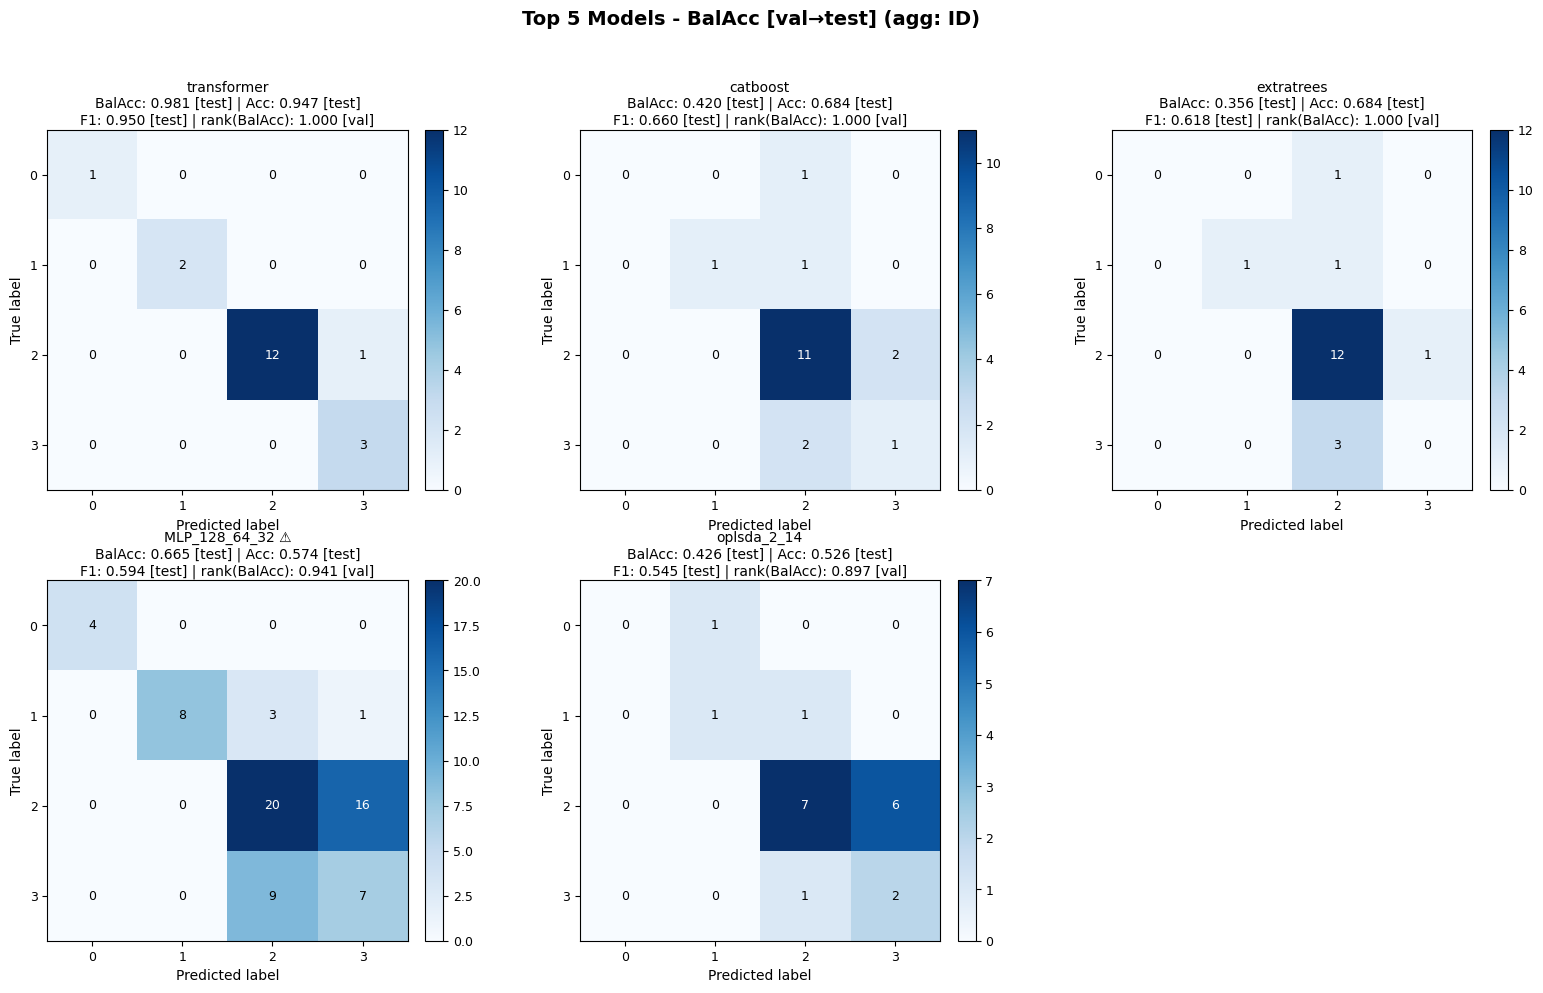

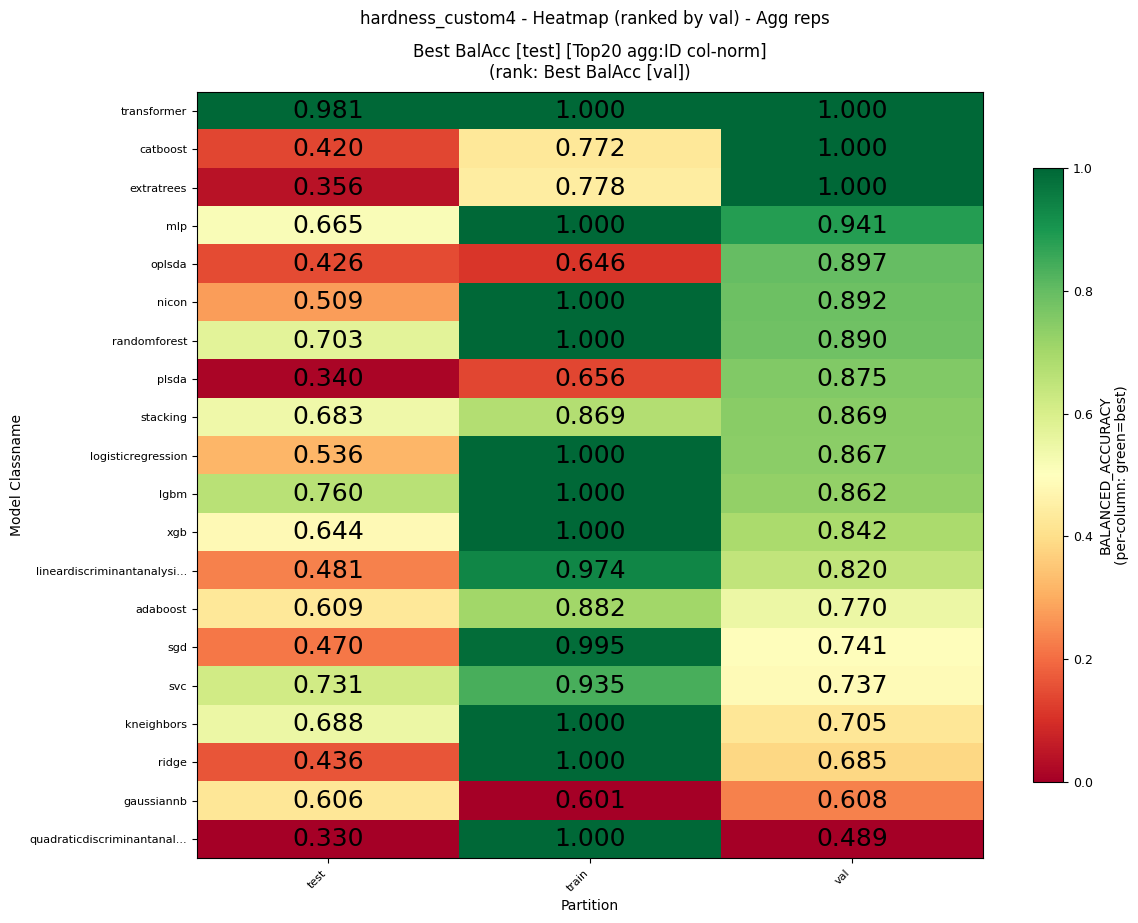

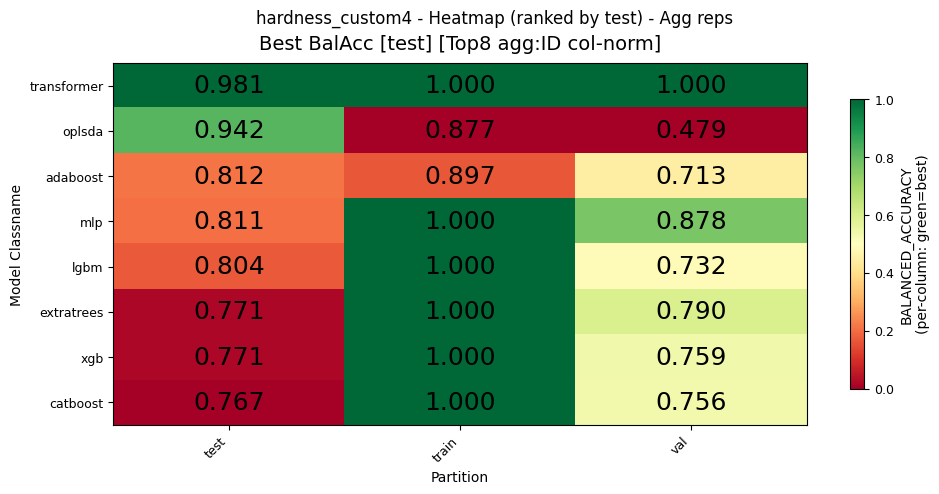

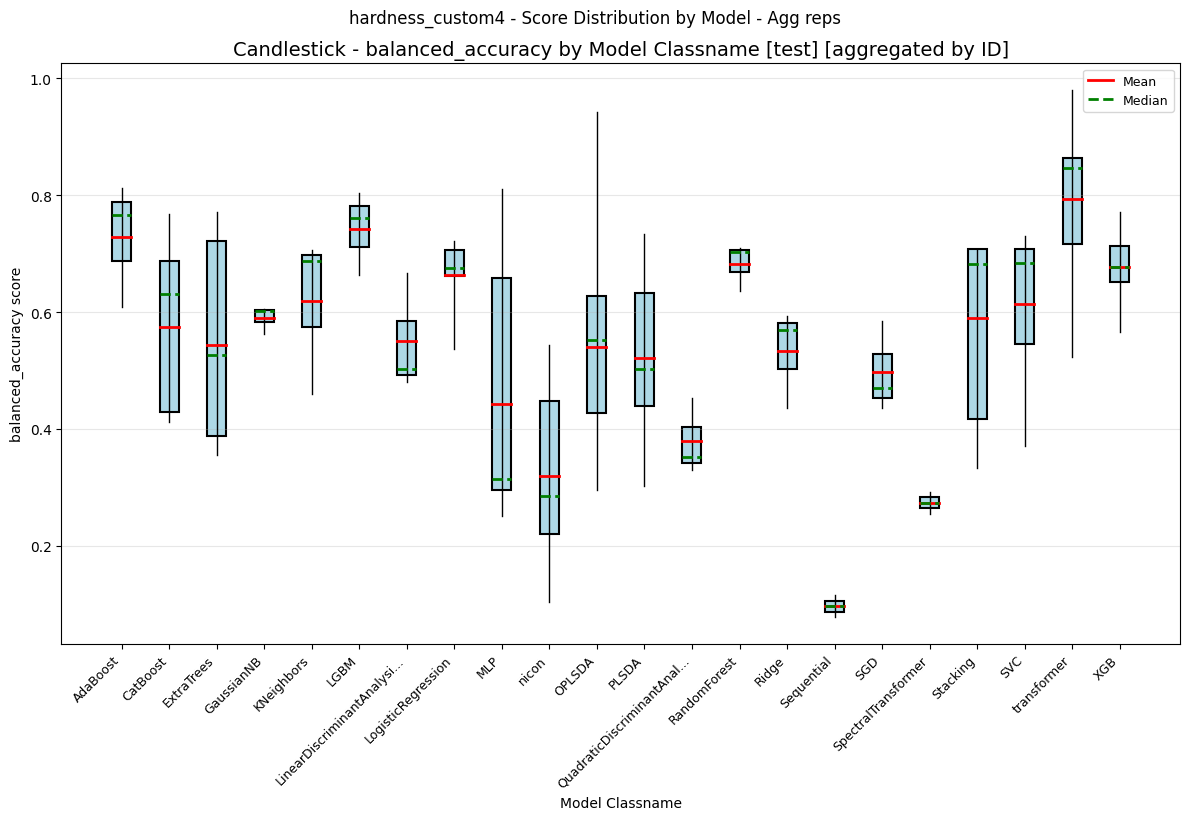

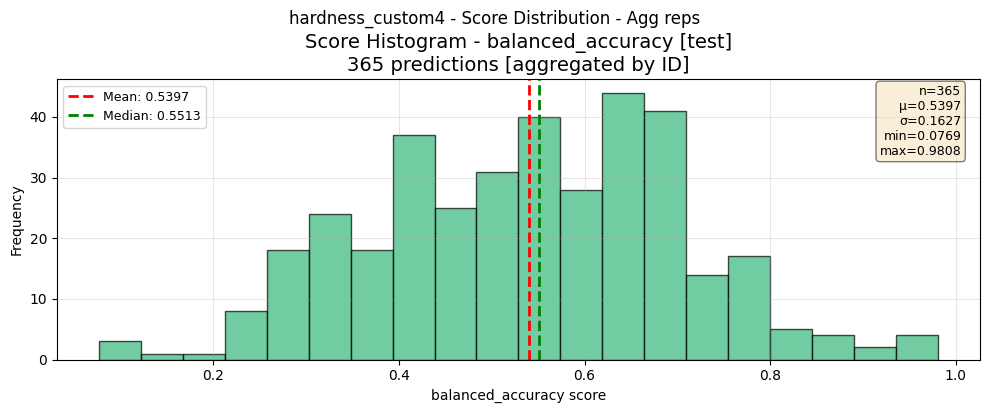

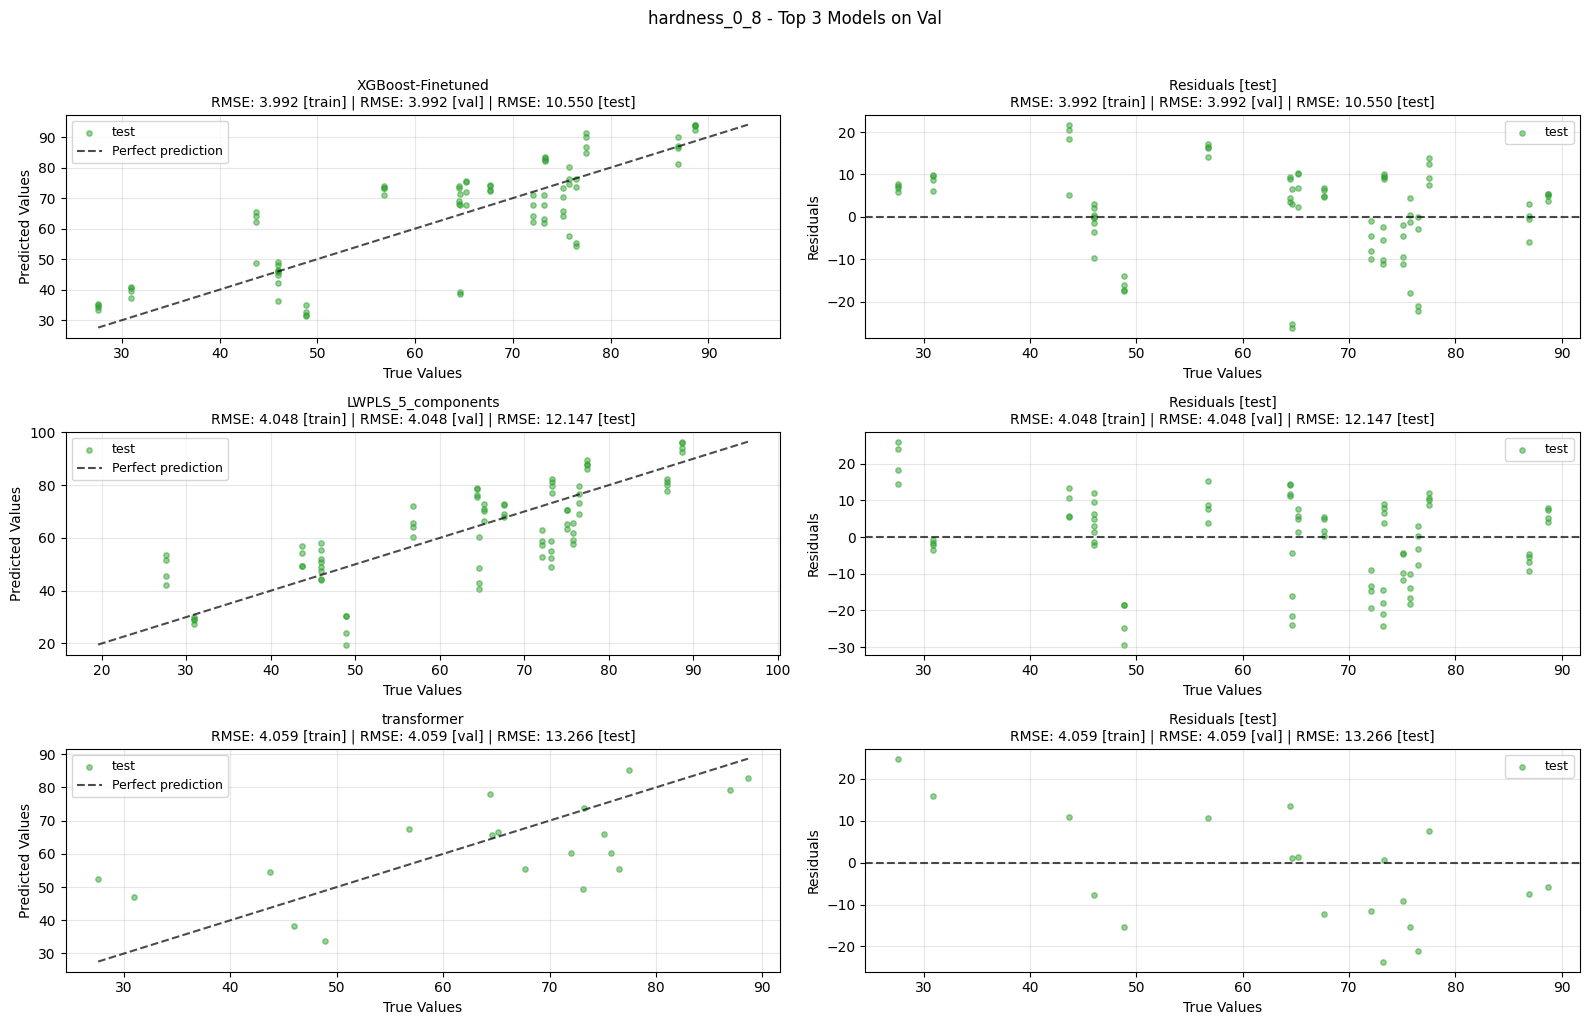

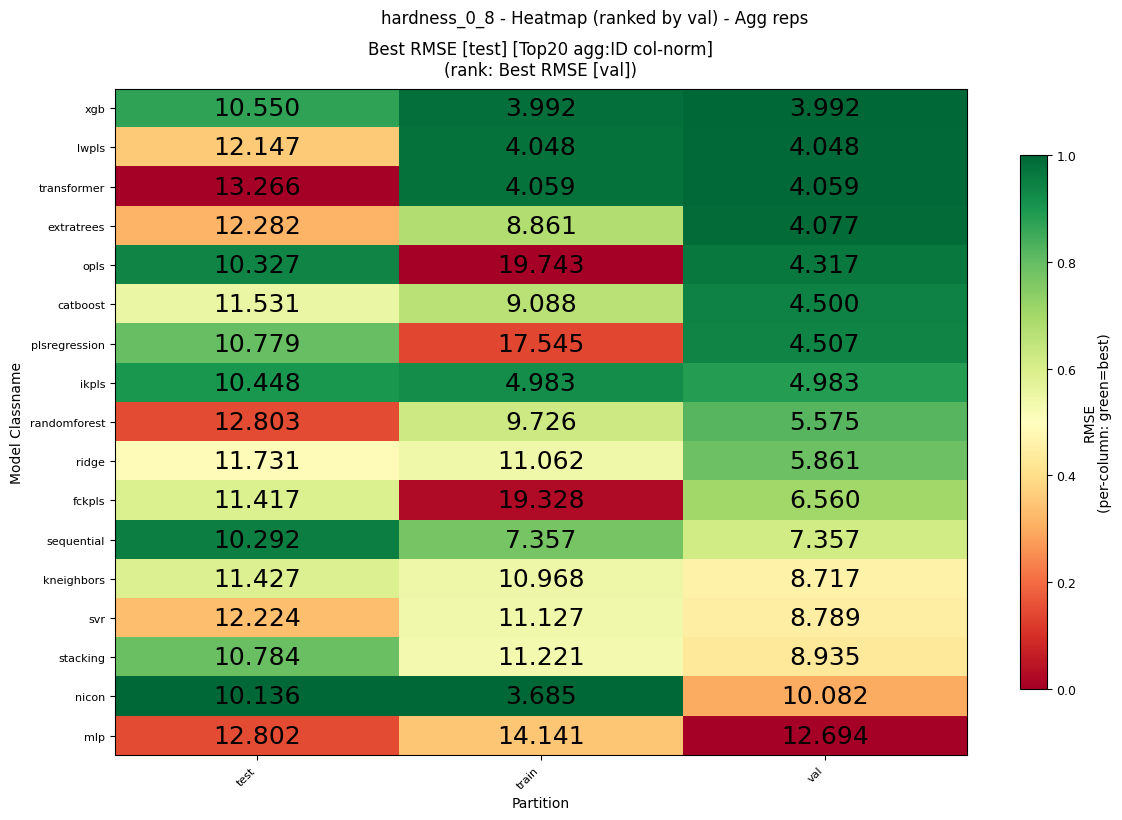

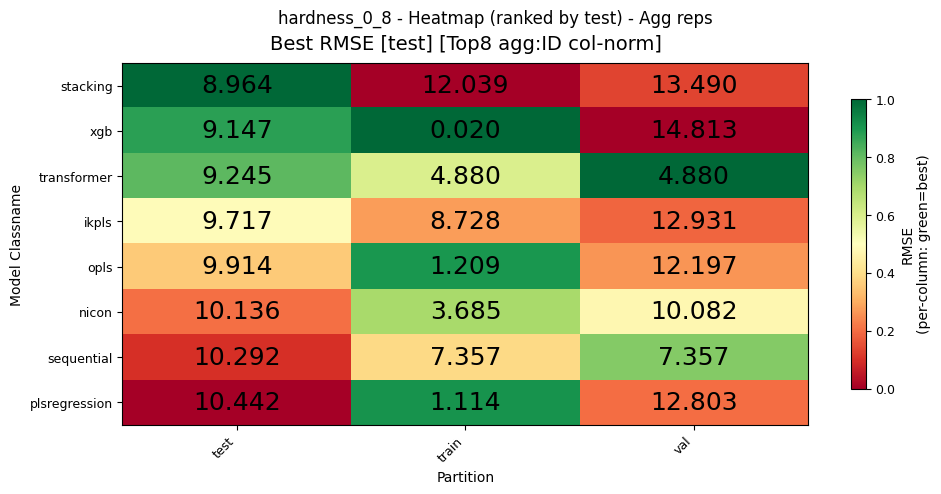

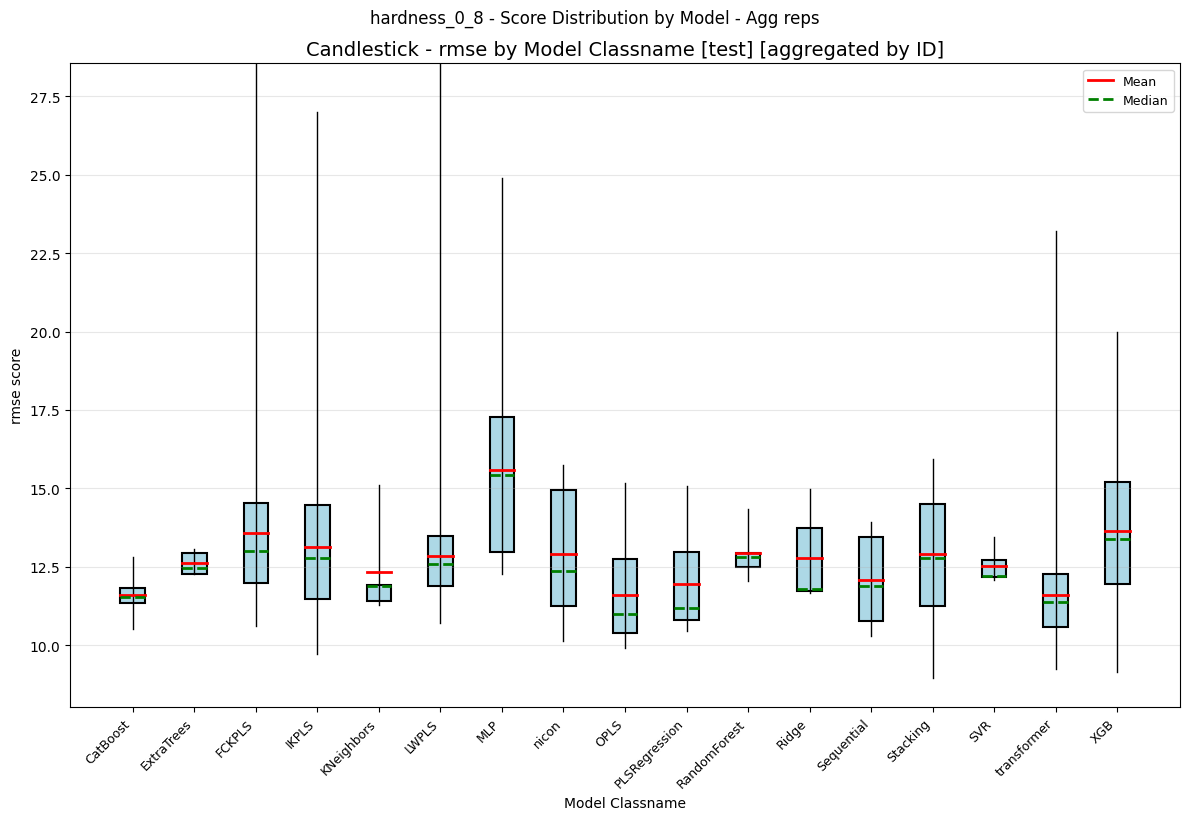

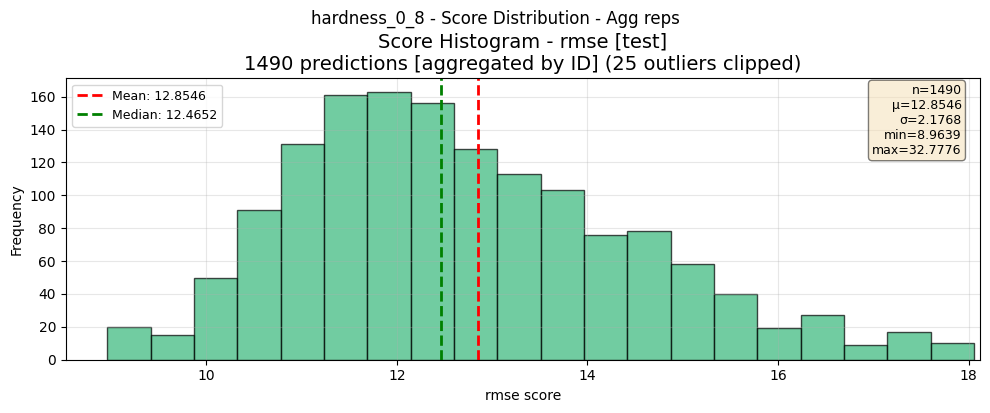

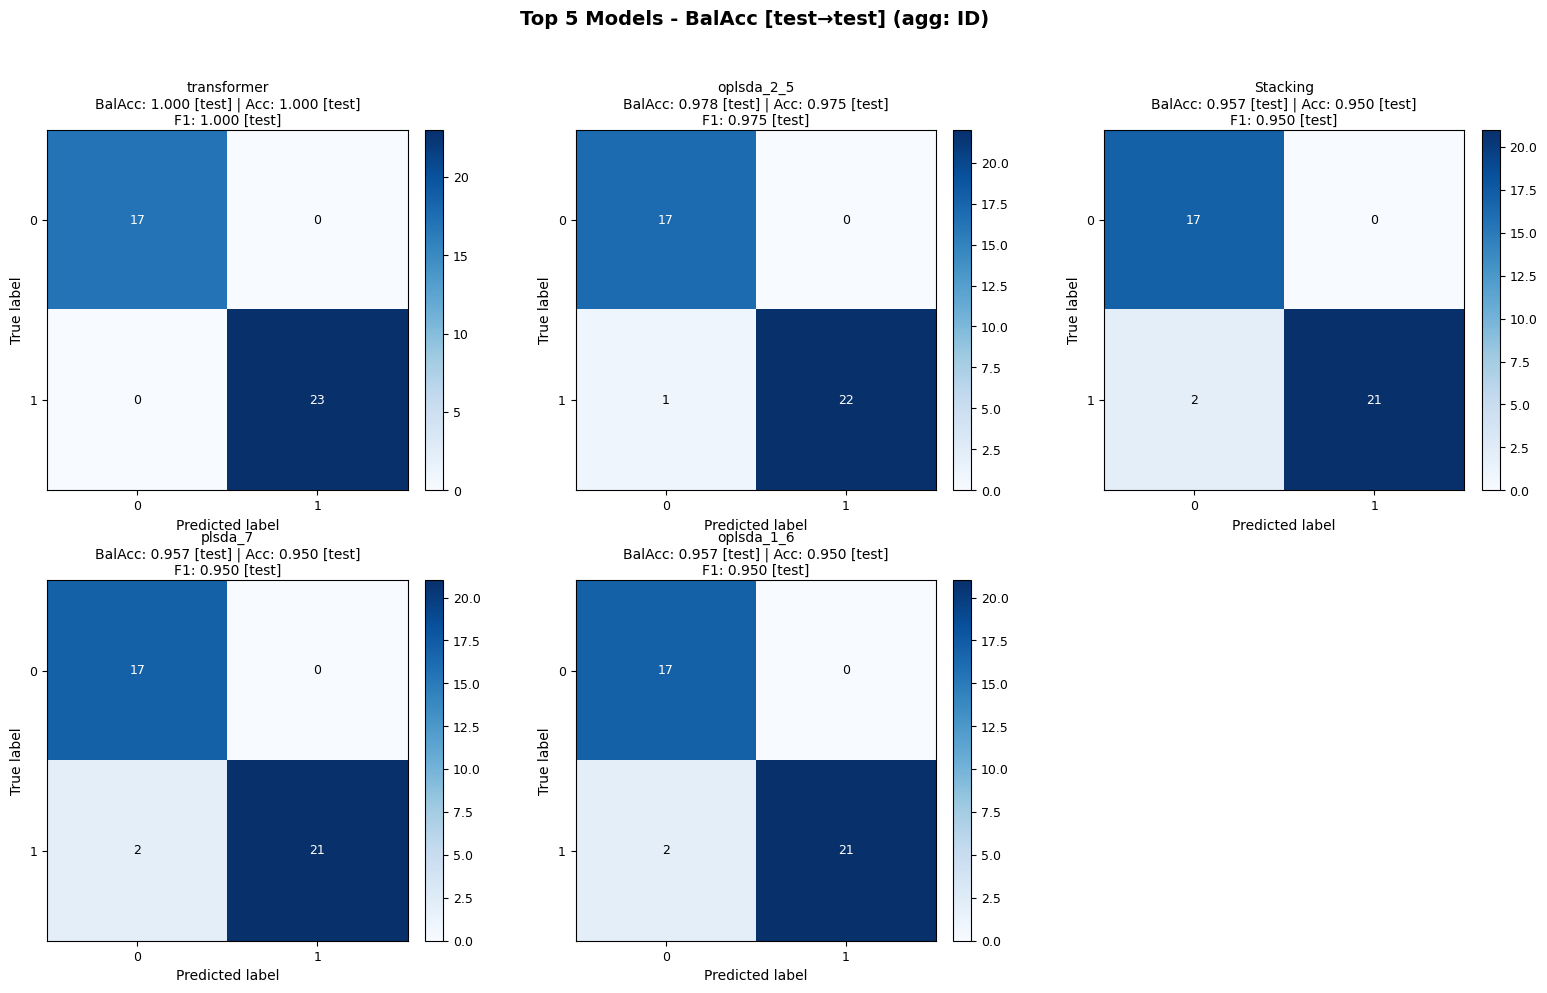

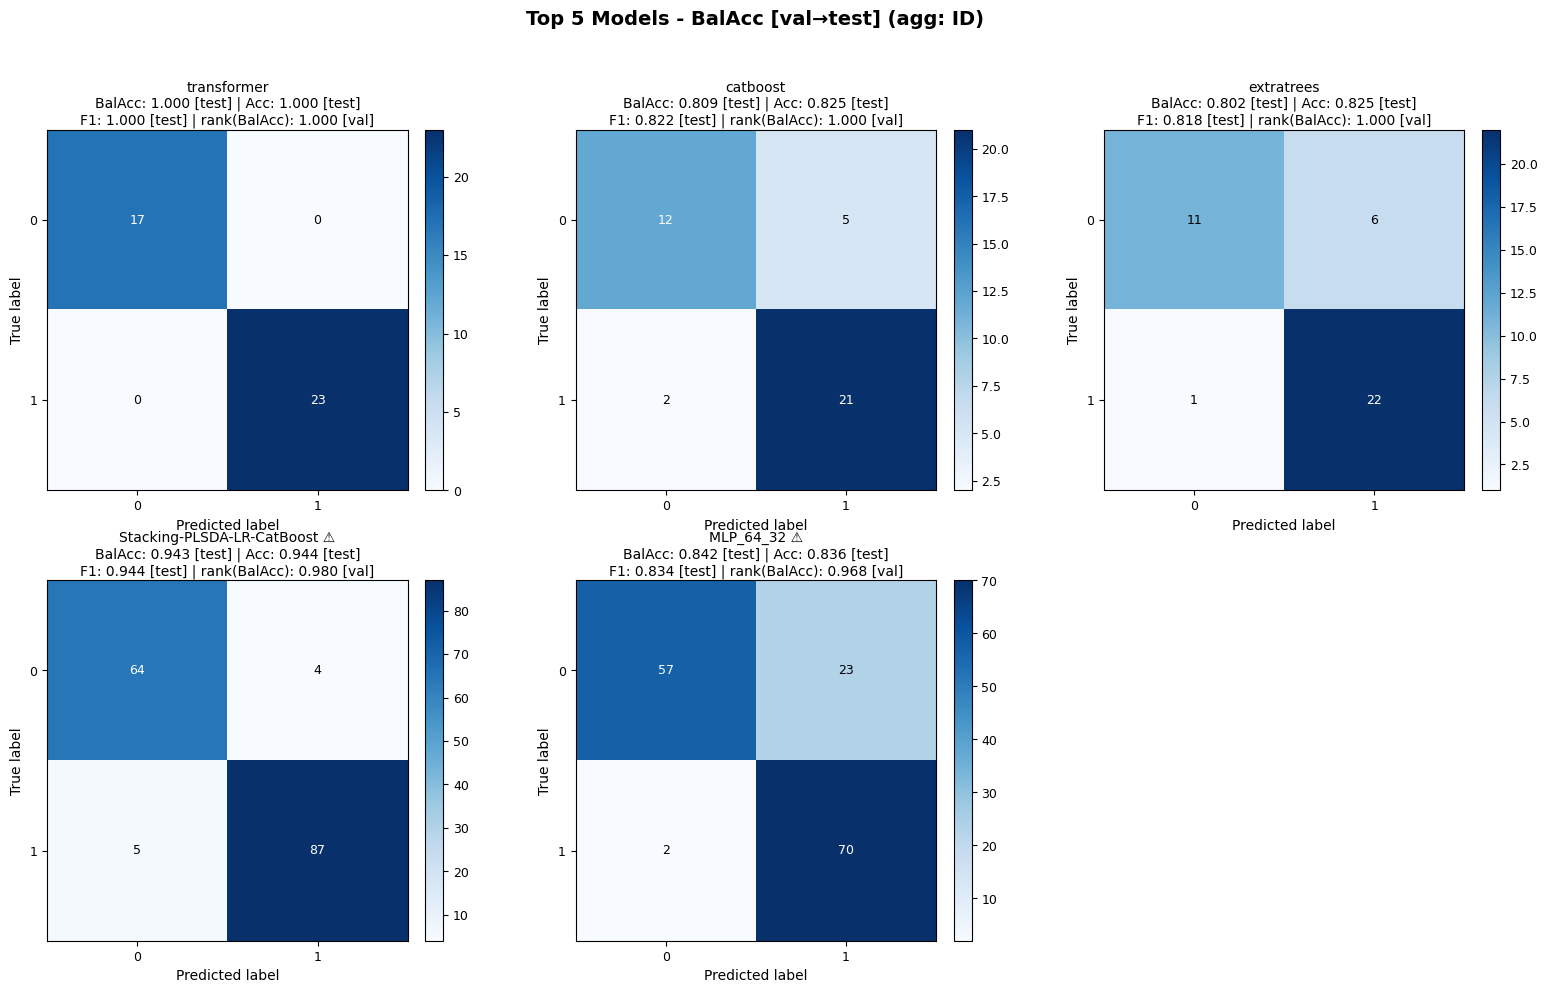

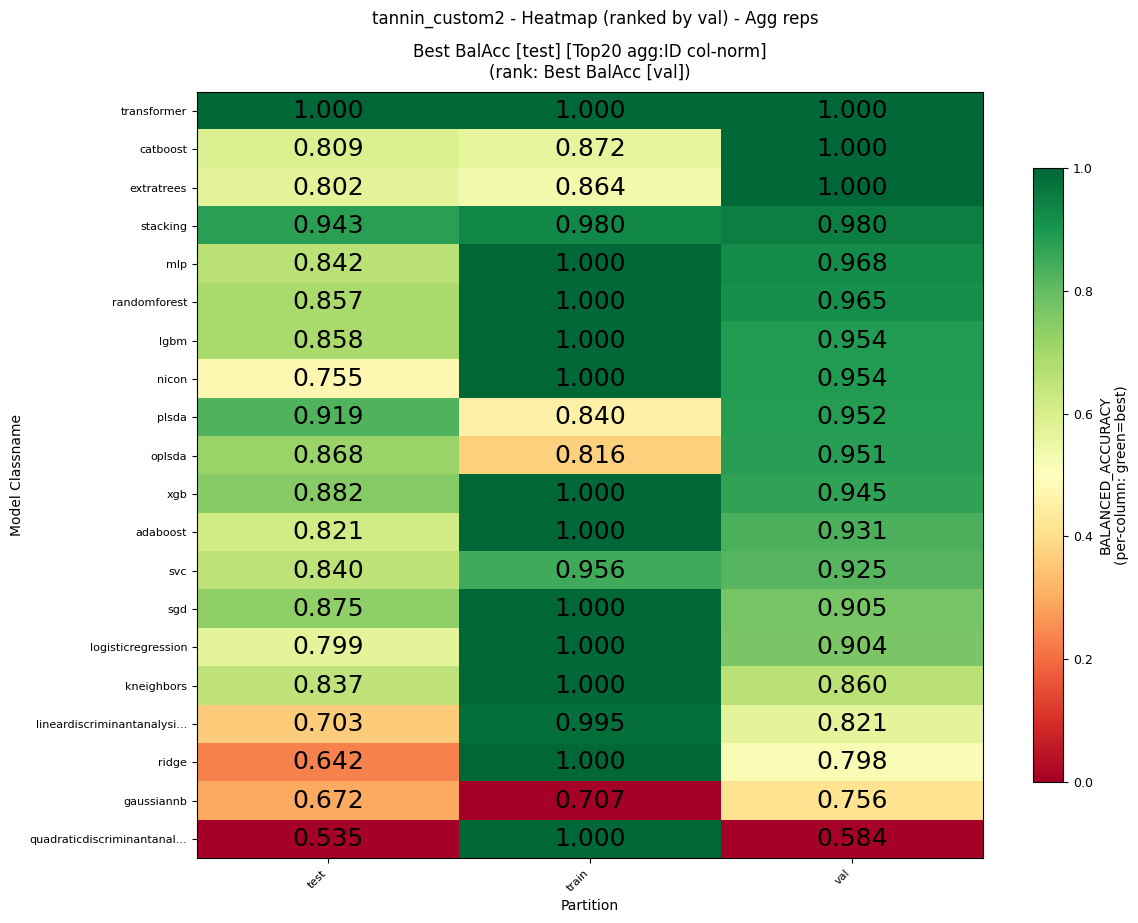

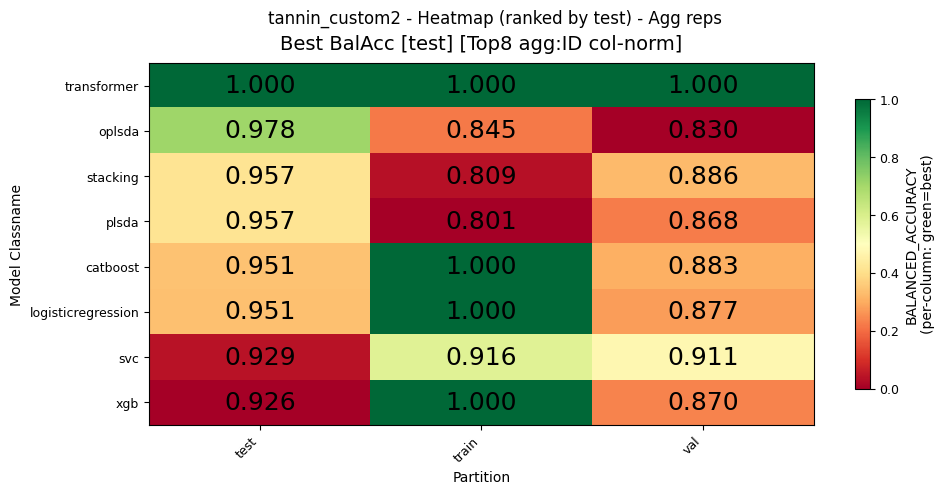

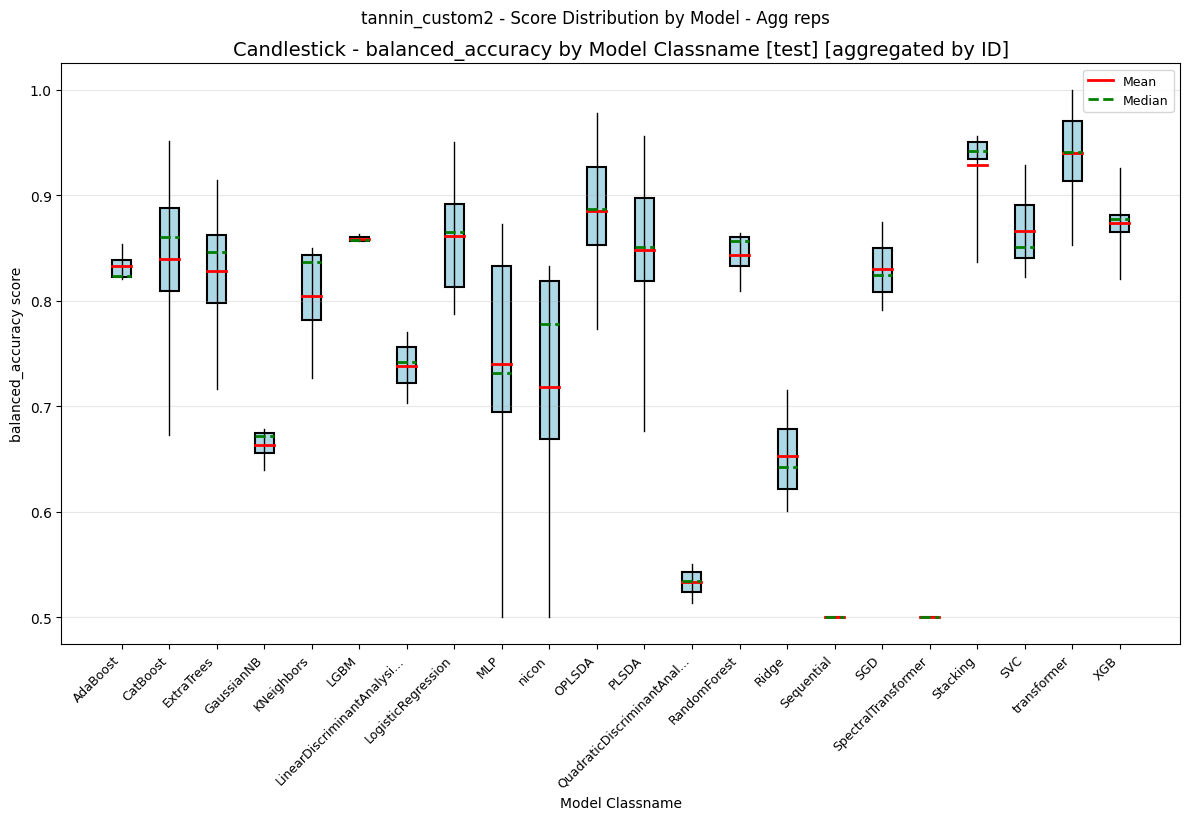

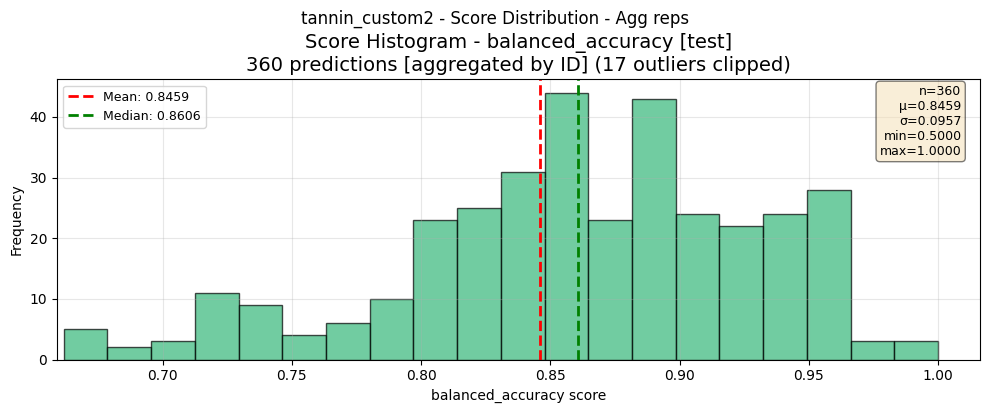

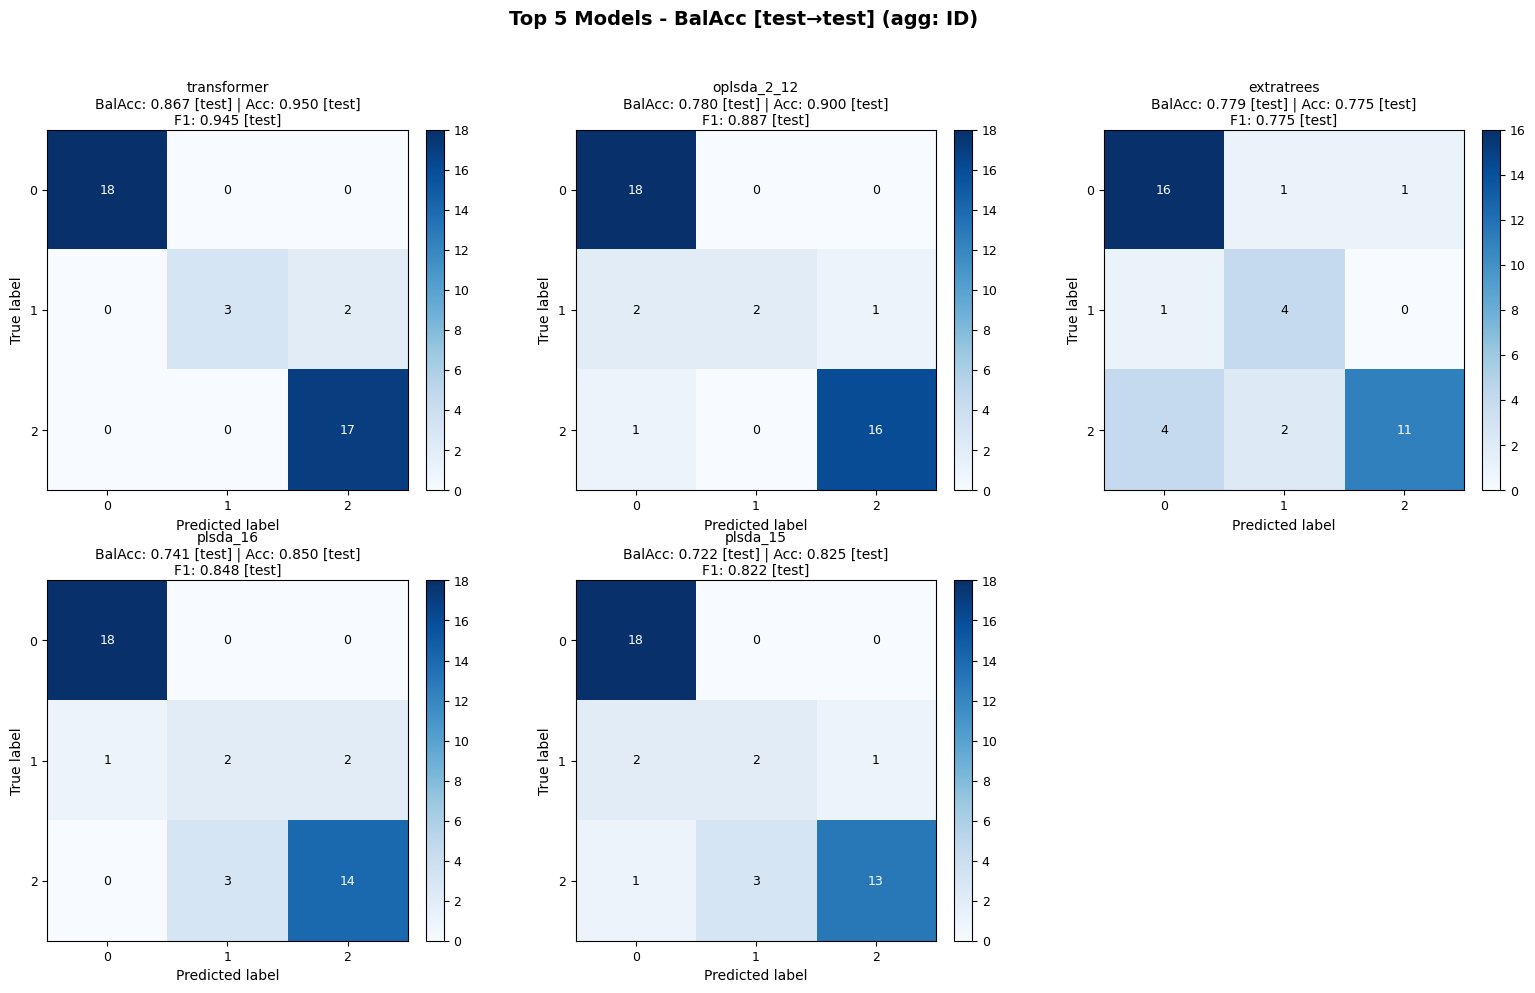

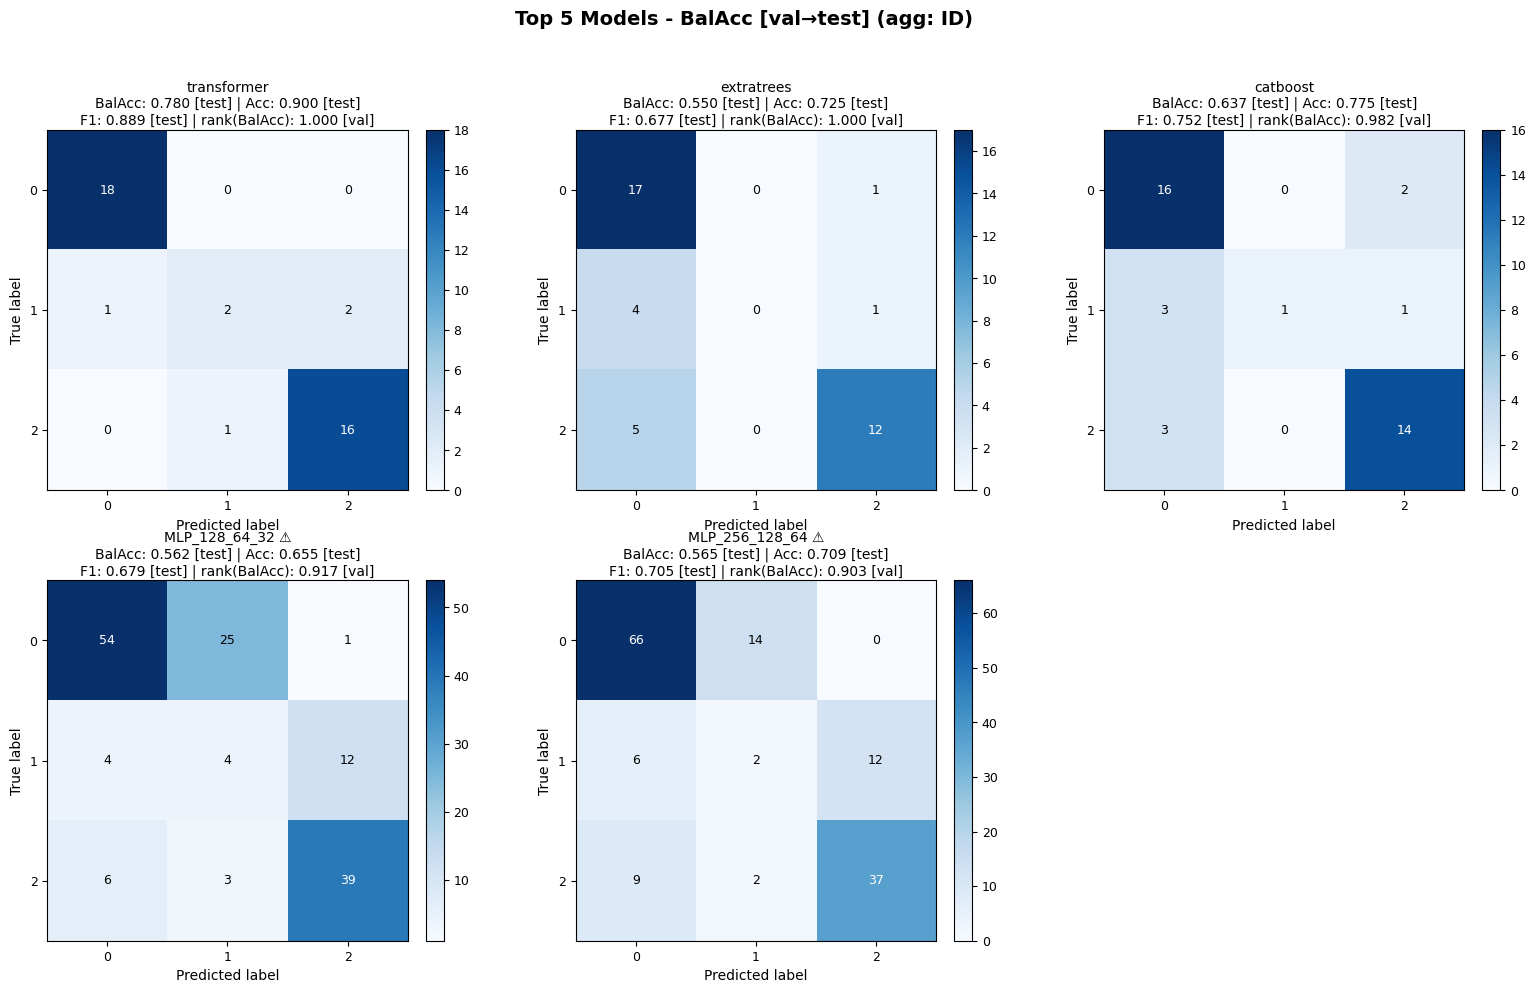

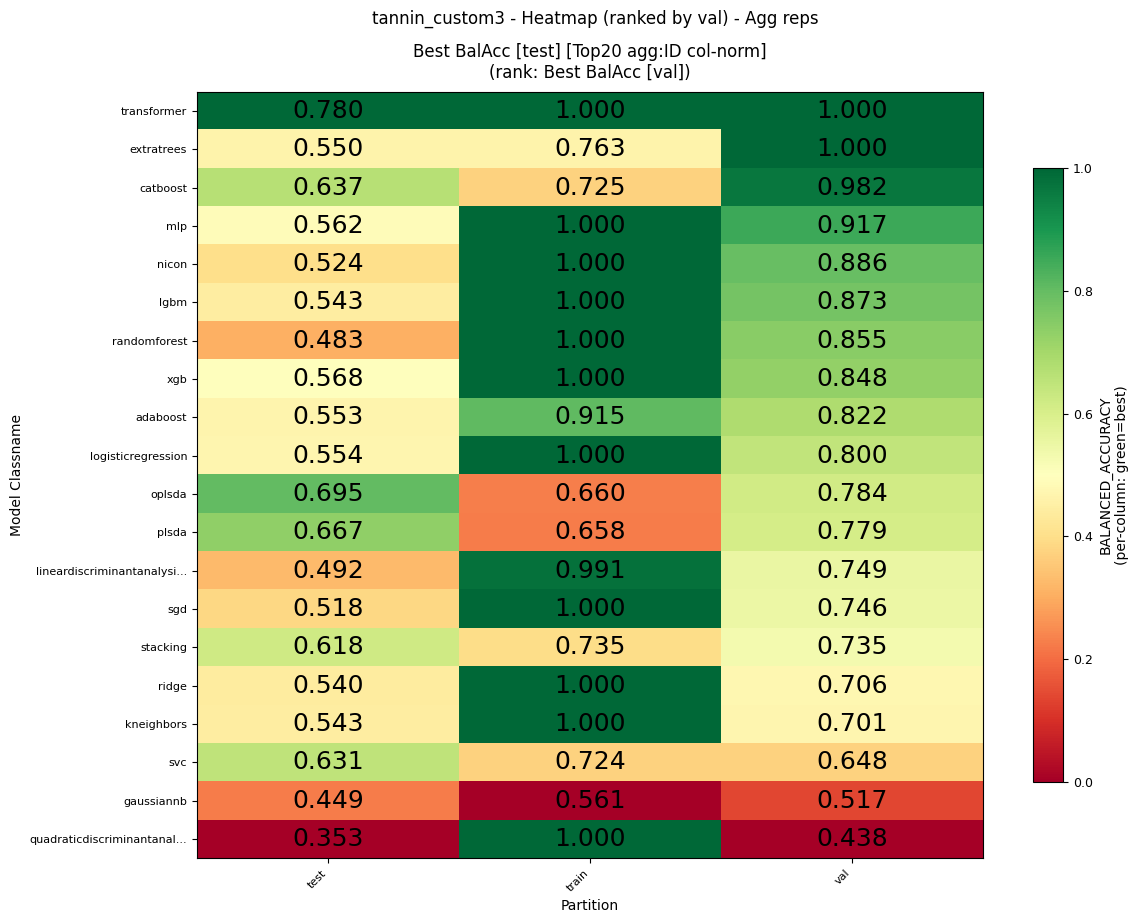

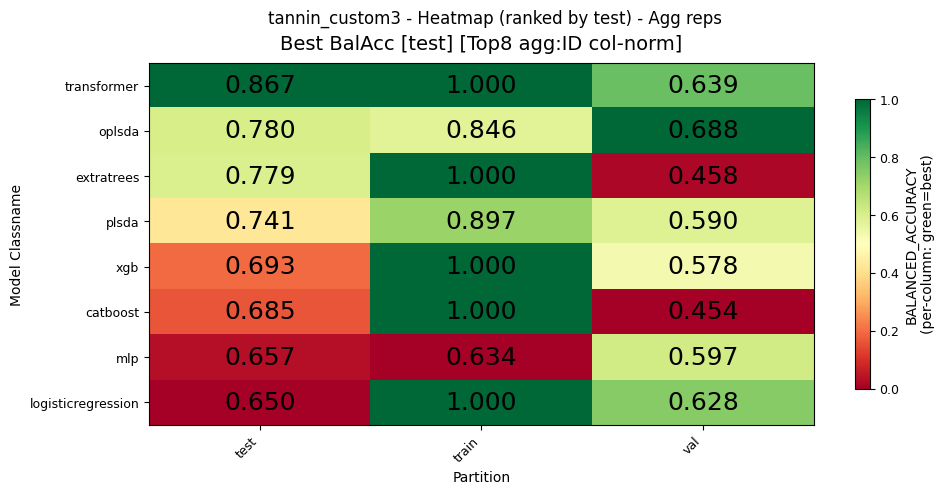

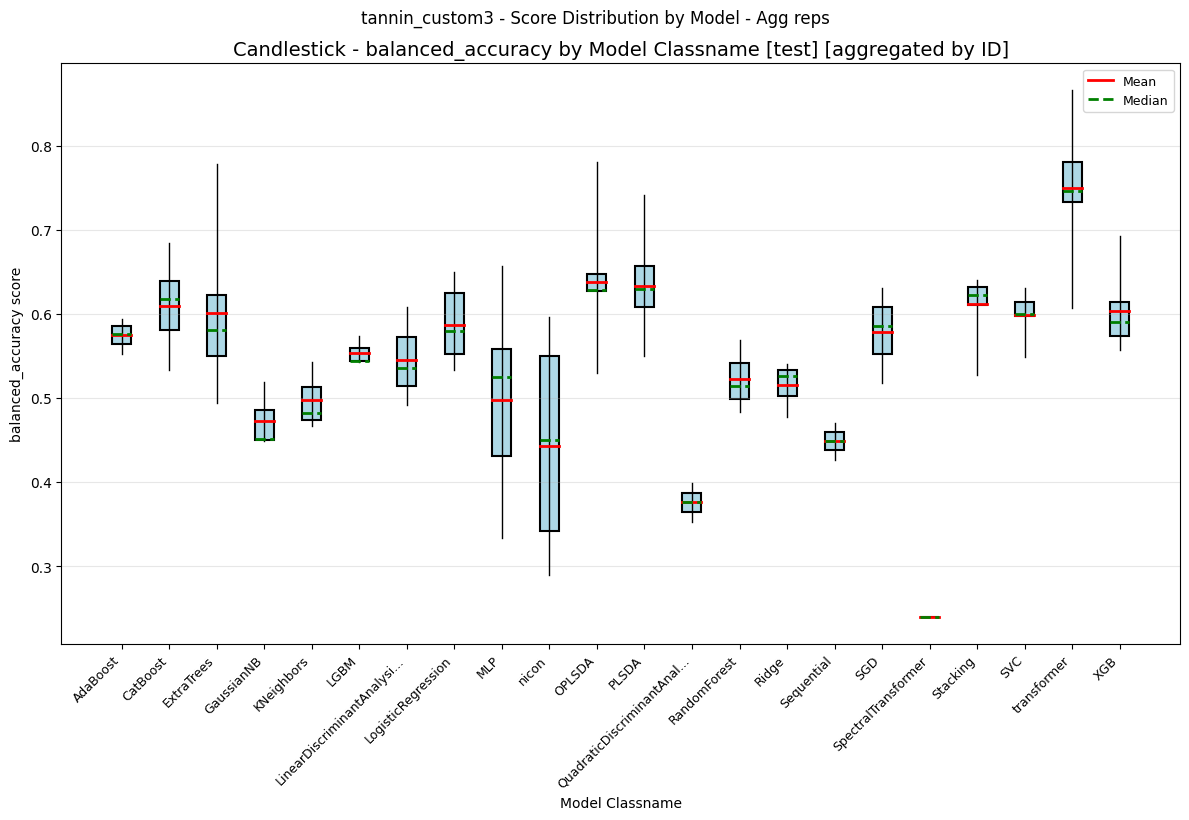

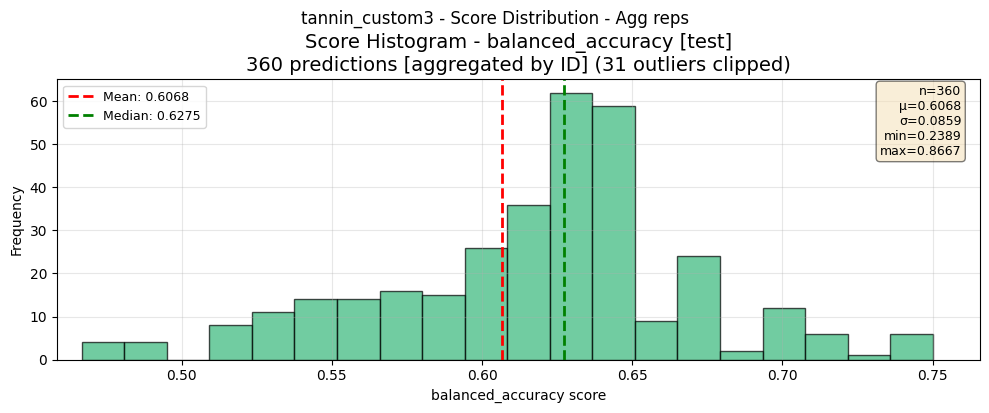

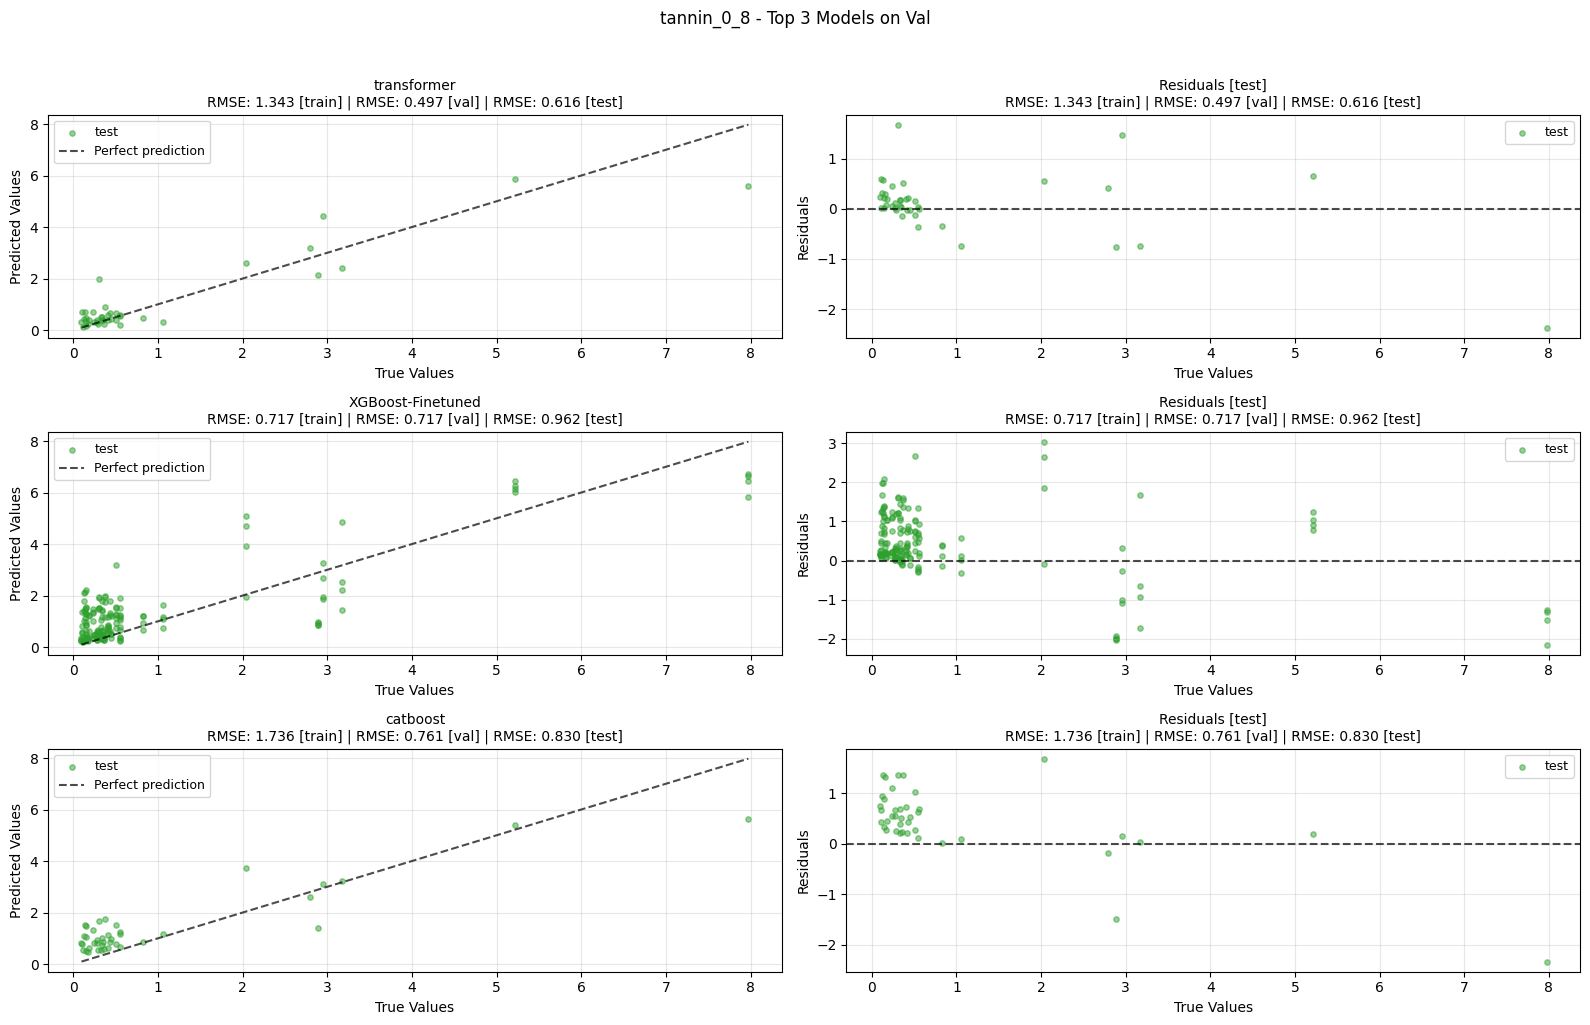

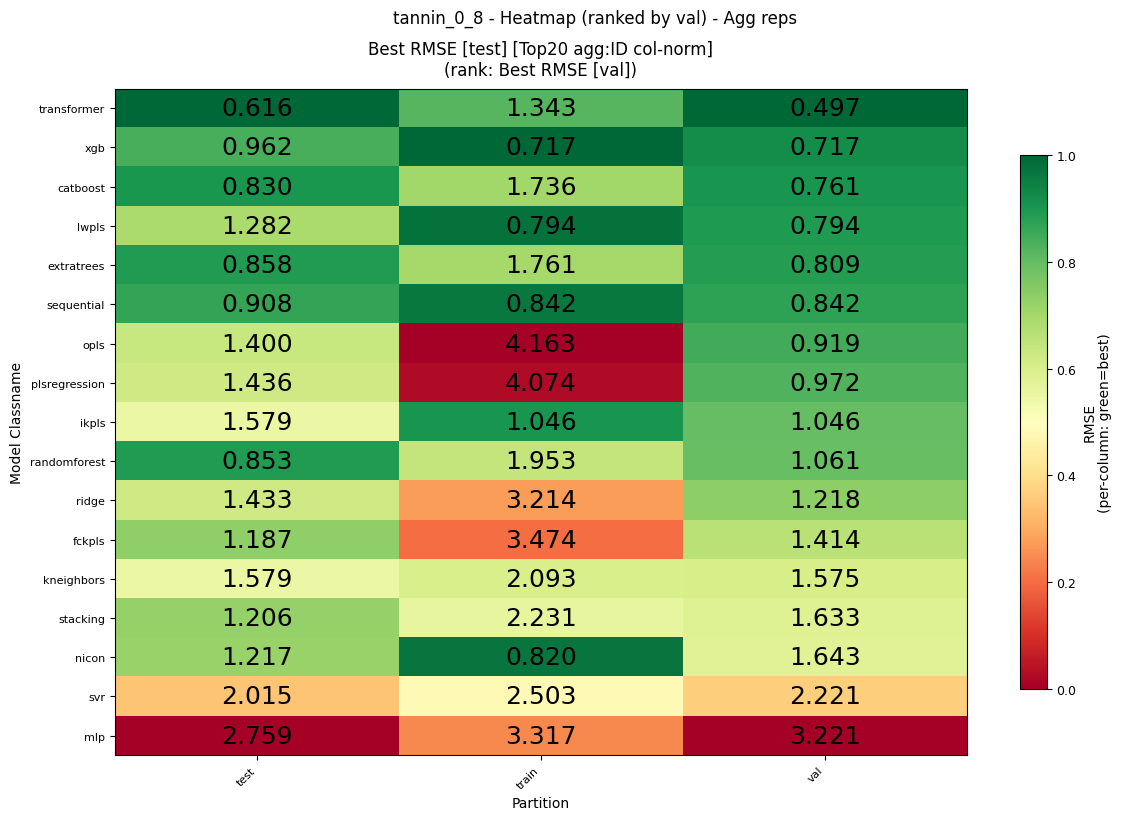

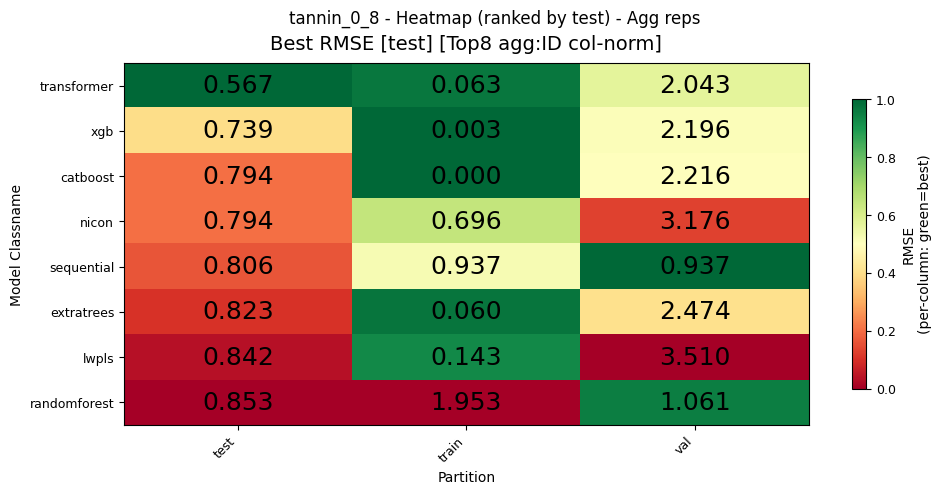

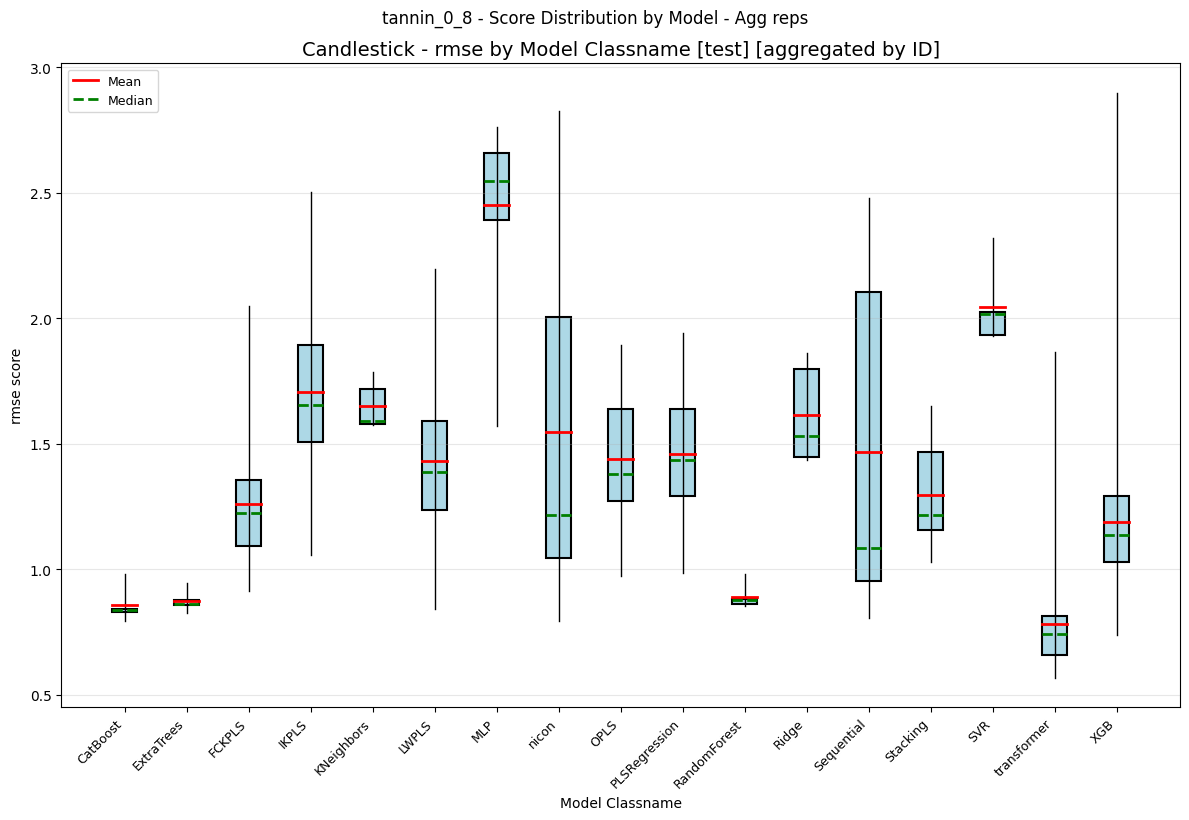

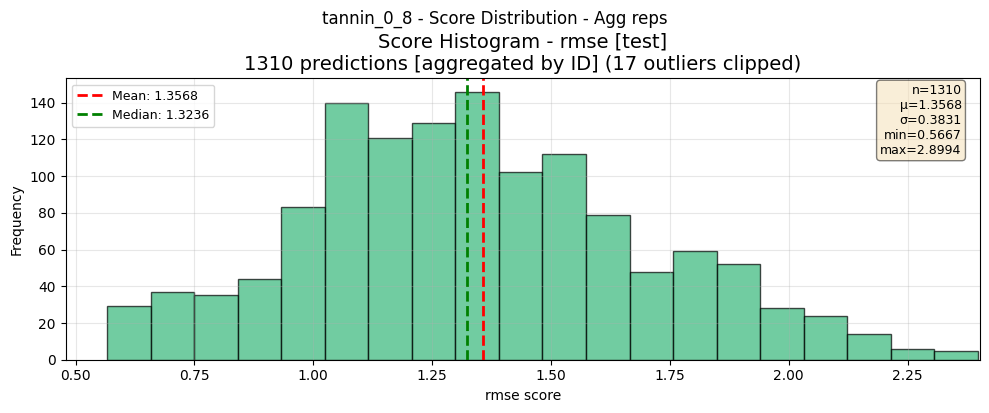

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import polars as pl
import re
from nirs4all.data import Predictions
from nirs4all.visualization.predictions import PredictionAnalyzer


def apply_model_filters(predictions: Predictions, exclude_models: list, rename_map: dict,
                        strip_suffixes: list = None) -> Predictions:
    """Filter out excluded models and rename model_classname values.

    Args:
        predictions: Predictions object to filter/rename.
        exclude_models: List of model_classname values to exclude (case-insensitive partial match).
        rename_map: Dict mapping old pattern to new names (case-insensitive partial match).
                   Example: {"tabpfn": "transformer"} will replace "TabPFNClassifier" with "transformer"
        strip_suffixes: List of suffixes to remove from model names (case-insensitive).
                       Default: ["Classifier", "Regressor"]

    Returns:
        Filtered and renamed Predictions object (modifies in place).
    """
    if strip_suffixes is None:
        strip_suffixes = ["classifier", "regressor"]

    df = predictions._storage._df
    original_count = len(df)

    # Exclude models (case-insensitive partial match)
    if exclude_models:
        # Build case-insensitive pattern for exclusion
        exclude_pattern = '(?i)(' + '|'.join(re.escape(m) for m in exclude_models) + ')'
        df = df.filter(~pl.col("model_classname").str.contains(exclude_pattern))
        excluded_count = original_count - len(df)
        if excluded_count > 0:
            print(f"  🚫 Excluded {excluded_count} predictions matching: {exclude_models}")

    # Strip suffixes first (case-insensitive)
    if strip_suffixes:
        # Build regex pattern for case-insensitive suffix removal
        suffix_pattern = '(?i)(' + '|'.join(re.escape(s) for s in strip_suffixes) + ')$'

        # Get unique model names before stripping
        unique_before = set(df["model_classname"].unique().to_list())

        # Apply suffix stripping to both model_classname and model_name
        df = df.with_columns([
            pl.col("model_classname").str.replace(suffix_pattern, "").alias("model_classname"),
            pl.col("model_name").str.replace(suffix_pattern, "").alias("model_name"),
        ])

        # Get unique model names after stripping
        unique_after = set(df["model_classname"].unique().to_list())

        # Report changes
        changed = unique_before - unique_after
        if changed:
            print(f"  ✂️ Stripped suffixes from model names: {sorted(changed)}")

    # Rename models using rename_map (case-insensitive partial match)
    if rename_map:
        for old_pattern, new_name in rename_map.items():
            # Case-insensitive pattern
            pattern = f'(?i){re.escape(old_pattern)}'

            # Count matches before rename
            match_count = df.filter(pl.col("model_classname").str.contains(pattern)).height

            if match_count > 0:
                # Replace the pattern with new_name (replaces entire string, not just pattern)
                # We want to replace the whole model name, not just the matching part
                df = df.with_columns([
                    pl.when(pl.col("model_classname").str.contains(pattern))
                    .then(pl.lit(new_name))
                    .otherwise(pl.col("model_classname"))
                    .alias("model_classname"),
                    pl.when(pl.col("model_name").str.contains(pattern))
                    .then(pl.lit(new_name))
                    .otherwise(pl.col("model_name"))
                    .alias("model_name"),
                ])
                print(f"  ✏️ Renamed {match_count} predictions matching '{old_pattern}' → '{new_name}'")

    predictions._storage._df = df
    return predictions


# Where to save charts
CHARTS_OUTPUT_DIR = "charts"

def save_figure(fig, name):
    """Save figure to charts output directory with multiple formats."""
    output_dir = Path(CHARTS_OUTPUT_DIR)
    output_dir.mkdir(exist_ok=True)

    for fmt in ['png']:
        path = output_dir / f"{filename}_{name}.{fmt}"
        fig.savefig(path, dpi=150, bbox_inches='tight')
        print(f"  📁 Saved: {path}")

for filename in filenames:
    predictions_path = f"{WORKSPACE_PATH}/{filename}.meta.parquet"
    print(predictions_path)
    # Load predictions
    predictions = Predictions.load(path=predictions_path)
    print(f"\n📂 Loaded {len(predictions)} predictions from {filename}")

    # Skip empty prediction files
    if len(predictions) == 0:
        print(f"  ⚠️ Skipping {filename} - no predictions found")
        continue

    # Apply model filtering and renaming
    predictions = apply_model_filters(predictions, EXCLUDE_MODELS, MODEL_RENAME_MAP)
    print(f"  ➡️ Using {len(predictions)} predictions after filtering")

    # Create analyzer - output_dir=None to disable auto-saving (we save manually with titles)
    analyzer = PredictionAnalyzer(
        predictions,
        output_dir=None,  # Disable internal auto-save to avoid duplicates
    )

    # Get the dataset name and determine the metric type
    datasets = predictions.get_datasets()
    dataset_name = datasets[0] if datasets else filename
    file_name = Path(filename).stem

    # Detect if classification or regression based on task_type stored in predictions
    task_types = predictions.get_unique_values('task_type')
    is_classification = any(t and 'classification' in str(t).lower() for t in task_types)

    if is_classification:
        # Use classification metrics
        rank_metric = 'balanced_accuracy'
        display_metrics = ['balanced_accuracy', 'accuracy', 'f1']
        print(f"  📋 Task type: Classification")
    else:
        # Use regression metrics
        rank_metric = 'rmse'
        display_metrics = ['rmse', 'mse', 'mae', 'r2']
        print(f"  📋 Task type: Regression")

    # Show top models
    print(f"\n📊 Top 5 models for {file_name}:")
    top_models = predictions.top(n=5, rank_metric=rank_metric, rank_partition='val', aggregate="ID")
    for i, model in enumerate(top_models, 1):
        # rank_score is stored at top level of PredictionResult after aggregation
        score = model.get('rank_score', 'N/A')
        model_name = model.get('model_name', 'Unknown')
        if isinstance(score, (int, float)):
            print(f"  {i}. {model_name}: {rank_metric}={score:.4f}")
        else:
            print(f"  {i}. {model_name}: {rank_metric}={score}")

    # Common heatmap config
    hm_config = {
        # 'fig_fontsize': 20,      # Default font size
        # 'title_fontsize': 24,     # Figure titles
        # 'legend_fontsize': 12,    # Legend text
        # 'axis_fontsize': 20,      # Axis labels
        # 'tick_fontsize': 16,      # Axis tick labels
        'annotation_fontsize': 18    # Text inside charts (heatmap cells, etc.)
    }

    # ============================
    # CHARTS
    # ============================
    print(f"\n=== Charts for {file_name} ===")

    # --- Confusion matrix (only for classification) ---
    if is_classification:
        print(f"\n🔲 Confusion matrix:")
        fig_cm = analyzer.plot_confusion_matrix(
            rank_metric=rank_metric,
            display_metric=rank_metric,
            display_partition='test',
            rank_partition='test',
            aggregate="ID",
        )
        # plt.suptitle(f"{file_name} - Confusion Matrix", y=1.02)
        save_figure(fig_cm, f"confusion_matrix_{rank_metric}")

        fig_cm = analyzer.plot_confusion_matrix(
            rank_metric=rank_metric,
            display_metric=rank_metric,
            display_partition='test',
            rank_partition='val',
            aggregate="ID",
        )
        # plt.suptitle(f"{file_name} - Confusion Matrix", y=1.02)
        save_figure(fig_cm, f"confusion_matrix_{rank_metric}_rank_val")

    # --- Top-K comparison (only for regression - scatter plots) ---
    if not is_classification:
        print(f"\n📈 Top-K comparisons:")
        # Top 3 models
        fig_top3 = analyzer.plot_top_k(
                k=3,
                rank_metric=rank_metric,
                rank_partition='val',
                display_partition='test',
                aggregate="ID"
            )
        plt.suptitle(f"{file_name} - Top 3 Models on Val", y=1.02)
        save_figure(fig_top3, f"top3_test_rank_val")

    # --- Heatmaps ---
    print(f"\n📊 Heatmaps:")
    # --- Heatmap ranked by VAL - Aggregated ---
    fig_heatmap = analyzer.plot_heatmap(
        x_var="partition",
        y_var="model_classname",
        rank_metric=rank_metric,
        display_metric=rank_metric,
        show_counts=False,
        rank_partition='val',
        aggregate="ID",
        column_scale = True,
        top_k=20,
        sort_by='value',
        config=hm_config
    )
    plt.suptitle(f"{file_name} - Heatmap (ranked by val) - Agg reps", y=1.02)
    save_figure(fig_heatmap, f"heatmap_{rank_metric}_rank_val_agg")

    # --- Heatmap ranked by TEST - Aggregated ---
    fig_heatmap = analyzer.plot_heatmap(
        x_var="partition",
        y_var="model_classname",
        rank_metric=rank_metric,
        display_metric=rank_metric,
        show_counts=False,
        rank_partition='test',
        aggregate="ID",
        column_scale = True,
        top_k=8,
        sort_by='value',
        config=hm_config
    )
    plt.suptitle(f"{file_name} - Heatmap (ranked by test) - Agg reps", y=1.02)
    save_figure(fig_heatmap, f"heatmap_{rank_metric}_rank_test_agg")

    # --- Candlestick plots ---
    print(f"\n📊 Candlestick plots:")
    fig_candlestick = analyzer.plot_candlestick(
        variable="model_classname",
        display_metric=rank_metric,
        display_partition='test',
        aggregate="ID"
    )
    plt.suptitle(f"{file_name} - Score Distribution by Model - Agg reps", y=1.02)
    save_figure(fig_candlestick, f"candlestick_{rank_metric}_test_agg")

    # --- Histograms ---
    print(f"\n📊 Histograms:")
    fig_histogram = analyzer.plot_histogram(
        display_metric=rank_metric,
        display_partition='test',
        aggregate="ID"
    )
    plt.suptitle(f"{file_name} - Score Distribution - Agg reps", y=1.02)
    save_figure(fig_histogram, f"histogram_{rank_metric}_test_agg")

    # Add more dataset comparisons here...
    print(f"\n✅ All charts generated for {file_name}")

print("\n🎉 All datasets processed!")